#  Ежедневные данные о временных рядах изменения климата

## О наборе данных

##### Содержание

Набор данных полностью предназначен для разработчиков, которые хотят обучить модель прогнозированию погоды для климата Индии. Этот набор данных предоставляет данные за период с 1 января 2013 года по 24 апреля 2017 года в городе Дели, Индия. 

Здесь указаны 4 параметра:
- `meantemp` - средняя температура [усредненный по часовому интервалу 3 часа в течении дня]
- `humidity` - влажность [грамм ^ 3]
- `wind_speed` - скорость ветра [км/ч]
- `meanpressure` - среднее давление [атм]

Ссылка kaggle: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

Целевой признак будет - средняя температура

Ежедневные климатические данные в городе Дели с 2013 по 2017 год

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Подключение библиотеки

In [1]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Для визуализации временных рядов
import plotly.graph_objects
import seaborn as sb
from scipy import stats as st
# Время обучения модели
import timeit
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson
# XGBRegressor
import xgboost as xgb

from lightgbm import LGBMRegressor
# Вызов библиотеки для отключения предупреждения
import warnings

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit
# Применим кроссвалидацию для повышения качеств обучения
# Для константной модели
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# и для машинного обучения разными способами (по условию мы выбираем линейную регрессию):
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import (
    # Точность модели
    accuracy_score,
    # Матрицы ошибок (для борьбы с дисбалансом)
    confusion_matrix, 
    # Полнота
    recall_score, 
    # Точность
    precision_score, 
    # F1-мера
    f1_score,
    # Метрика AUC-ROC
    roc_auc_score,
    roc_curve,
    # MSE
    mean_squared_error,
    mean_absolute_error,
    fbeta_score, 
    make_scorer
)

# Контроль выборки
from sklearn.utils import shuffle

### Загрузим данные

In [2]:
# Получаем датасет
try:
    # Сразу устанавливаем время как индексы
    df_train = pd.read_csv('DailyDelhiClimateTrain.csv', index_col=[0], parse_dates=[0])
    df_test = pd.read_csv('DailyDelhiClimateTest.csv', index_col=[0], parse_dates=[0])
except Exception as error:
    print('Отсутствует датасет. Проверьте путь файла')
    print('ERROR:', error)

### Изучим данные

#### Обучающий датасет

In [3]:
display(df_train.info())

display(df_train.describe())

display(df_train.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


None

meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333

meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000

#### Тестируемый датасет

In [4]:
display(df_test.info())

display(df_test.describe())

display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      114 non-null    float64
 1   humidity      114 non-null    float64
 2   wind_speed    114 non-null    float64
 3   meanpressure  114 non-null    float64
dtypes: float64(4)
memory usage: 4.5 KB


None

meantemp    humidity  wind_speed  meanpressure
count  114.000000  114.000000  114.000000    114.000000
mean    21.713079   56.258362    8.143924   1004.035090
std      6.360072   19.068083    3.588049     89.474692
min     11.000000   17.750000    1.387500     59.000000
25%     16.437198   39.625000    5.563542   1007.437500
50%     19.875000   57.750000    8.069444   1012.739316
75%     27.705357   71.902778   10.068750   1016.739583
max     34.500000   95.833333   19.314286   1022.809524

meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333

## Предобработка данных

### Пропуски

In [5]:
df_train.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [6]:
df_test.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

### Дублирующие значения

In [7]:
df_train.duplicated().sum()

0

In [8]:
df_test.duplicated().sum()

0

## Анализ

### Первый график временного ряда

#### Средняя температура

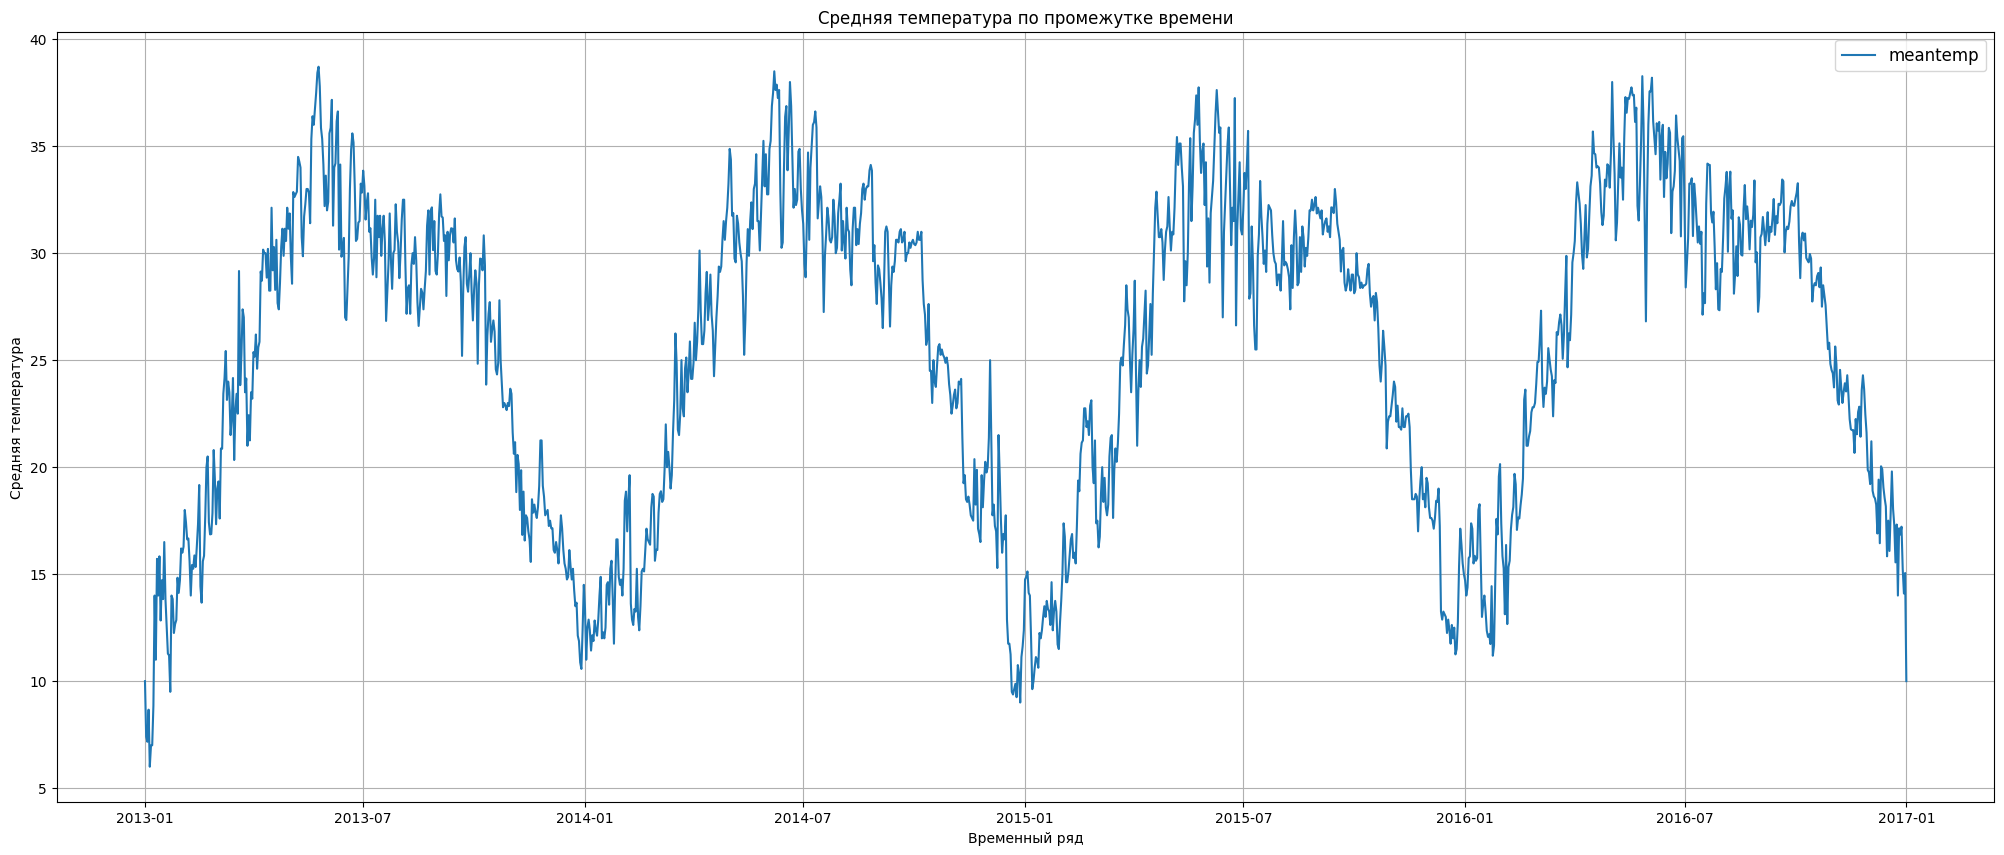

In [9]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['meantemp'])
ax_year.grid()

plt.title('Средняя температура по промежутке времени')
ax_year.set_xlabel('Временный ряд')
ax_year.set_ylabel('Средняя температура')
ax_year.legend(['meantemp'], fontsize='larger')

plt.show()

Наблюдается тенденция увеличения температуры в летний сезон и спадения в зимний сезон

#### Влажность

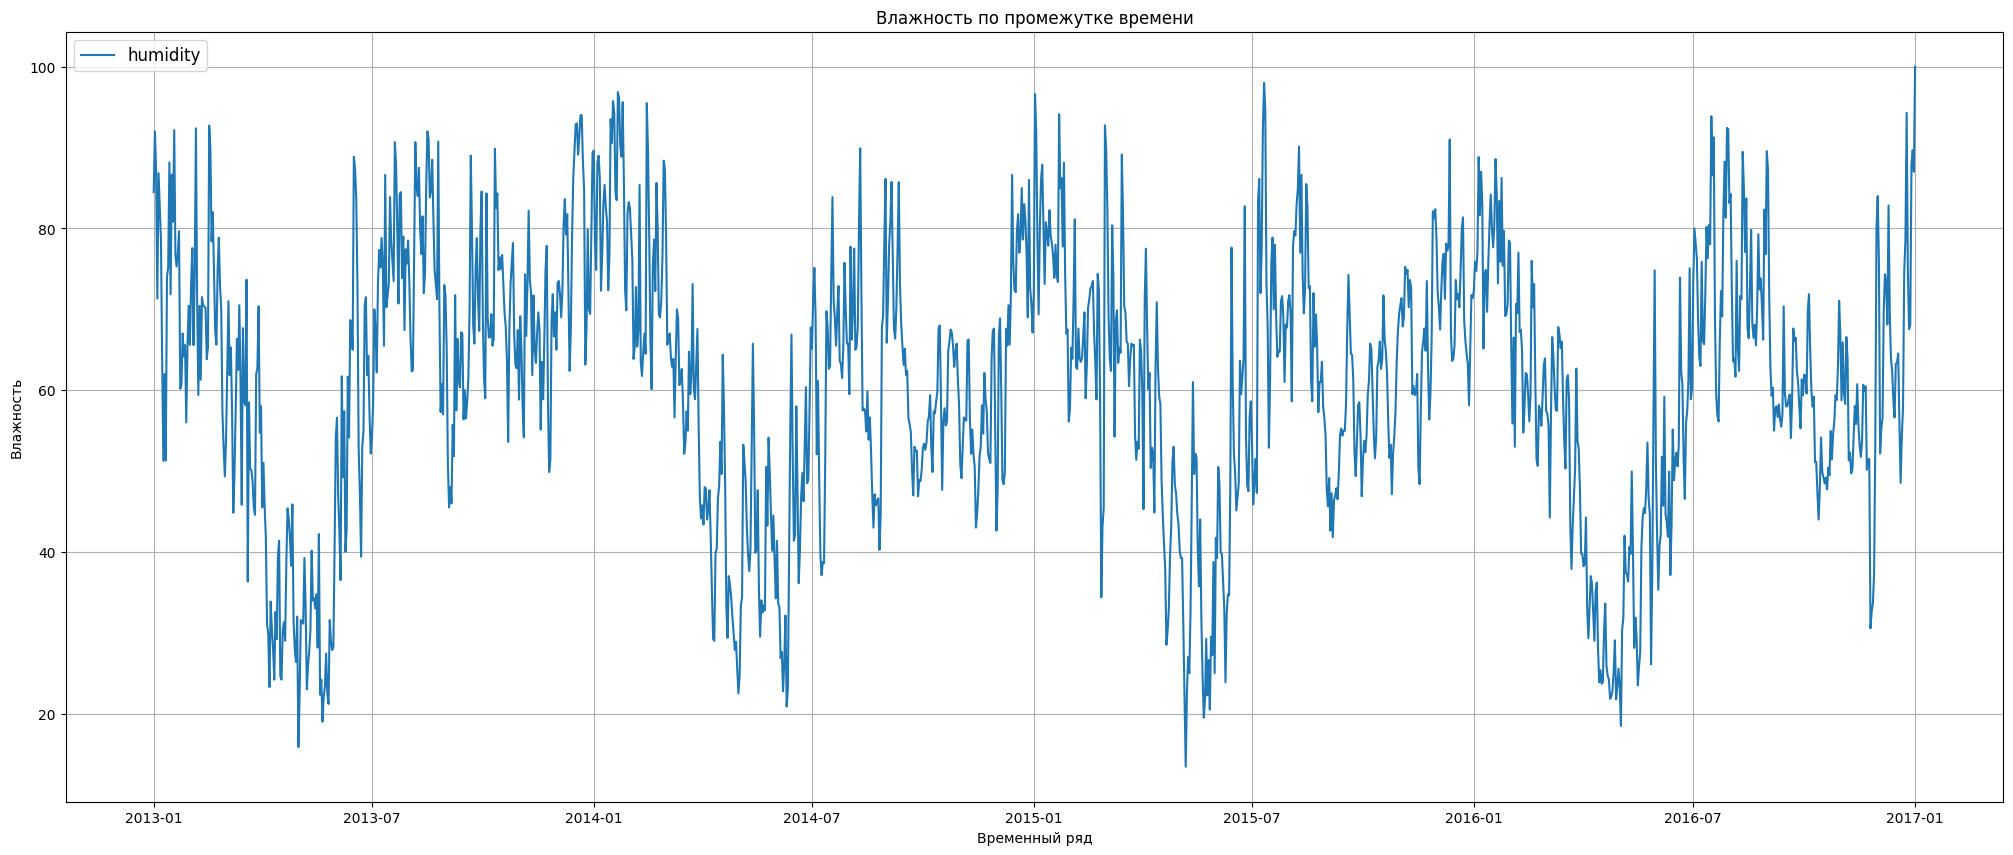

In [10]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['humidity'])
ax_year.grid()

plt.title('Влажность по промежутке времени')
ax_year.set_xlabel('Временный ряд')
ax_year.set_ylabel('Влажность')
ax_year.legend(['humidity'], fontsize='larger')

plt.show()

Здесь наблюдается противоположность по отношению к температуры, т.е. температура увеличивается, влажность уменьшается

#### Скорость ветра

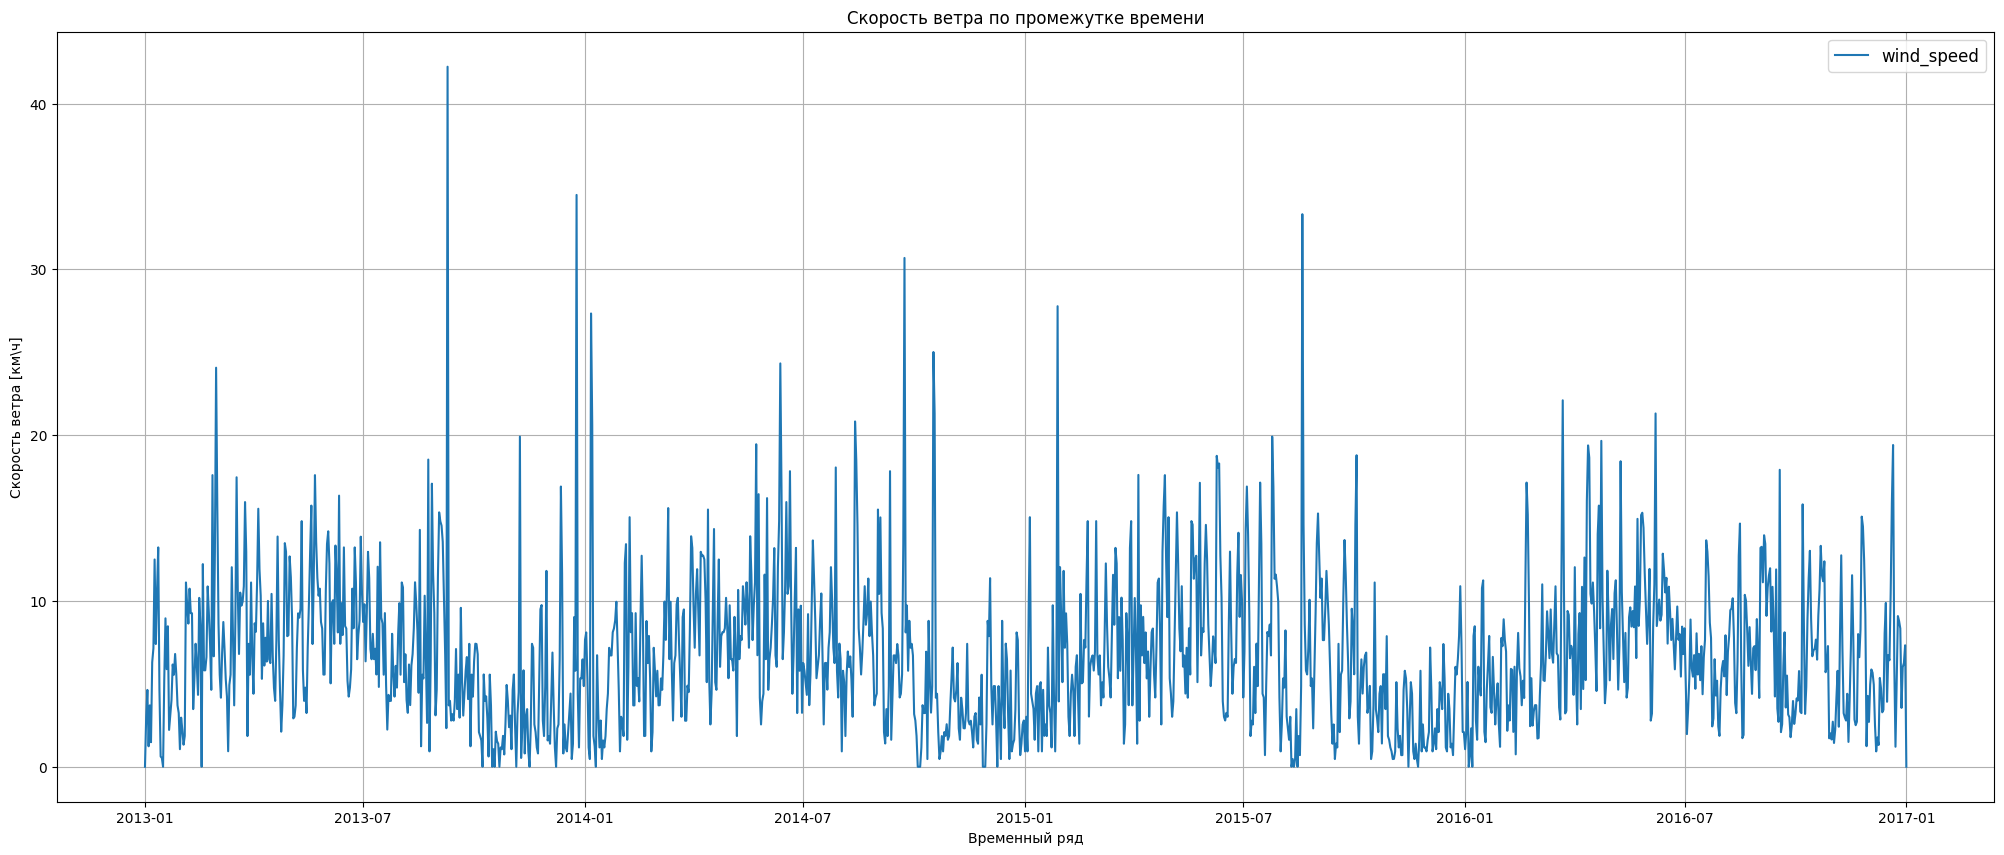

In [11]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['wind_speed'])
ax_year.grid()

plt.title('Скорость ветра по промежутке времени')
ax_year.set_xlabel('Временный ряд')
ax_year.set_ylabel('Скорость ветра [км\ч]')
ax_year.legend(['wind_speed'], fontsize='larger')

plt.show()

Скорость ветра не сильно привязан к вышеперичсленному признаку, она сама по себе, но иногда встречается всплеск огромной скорости

#### Среднее давление

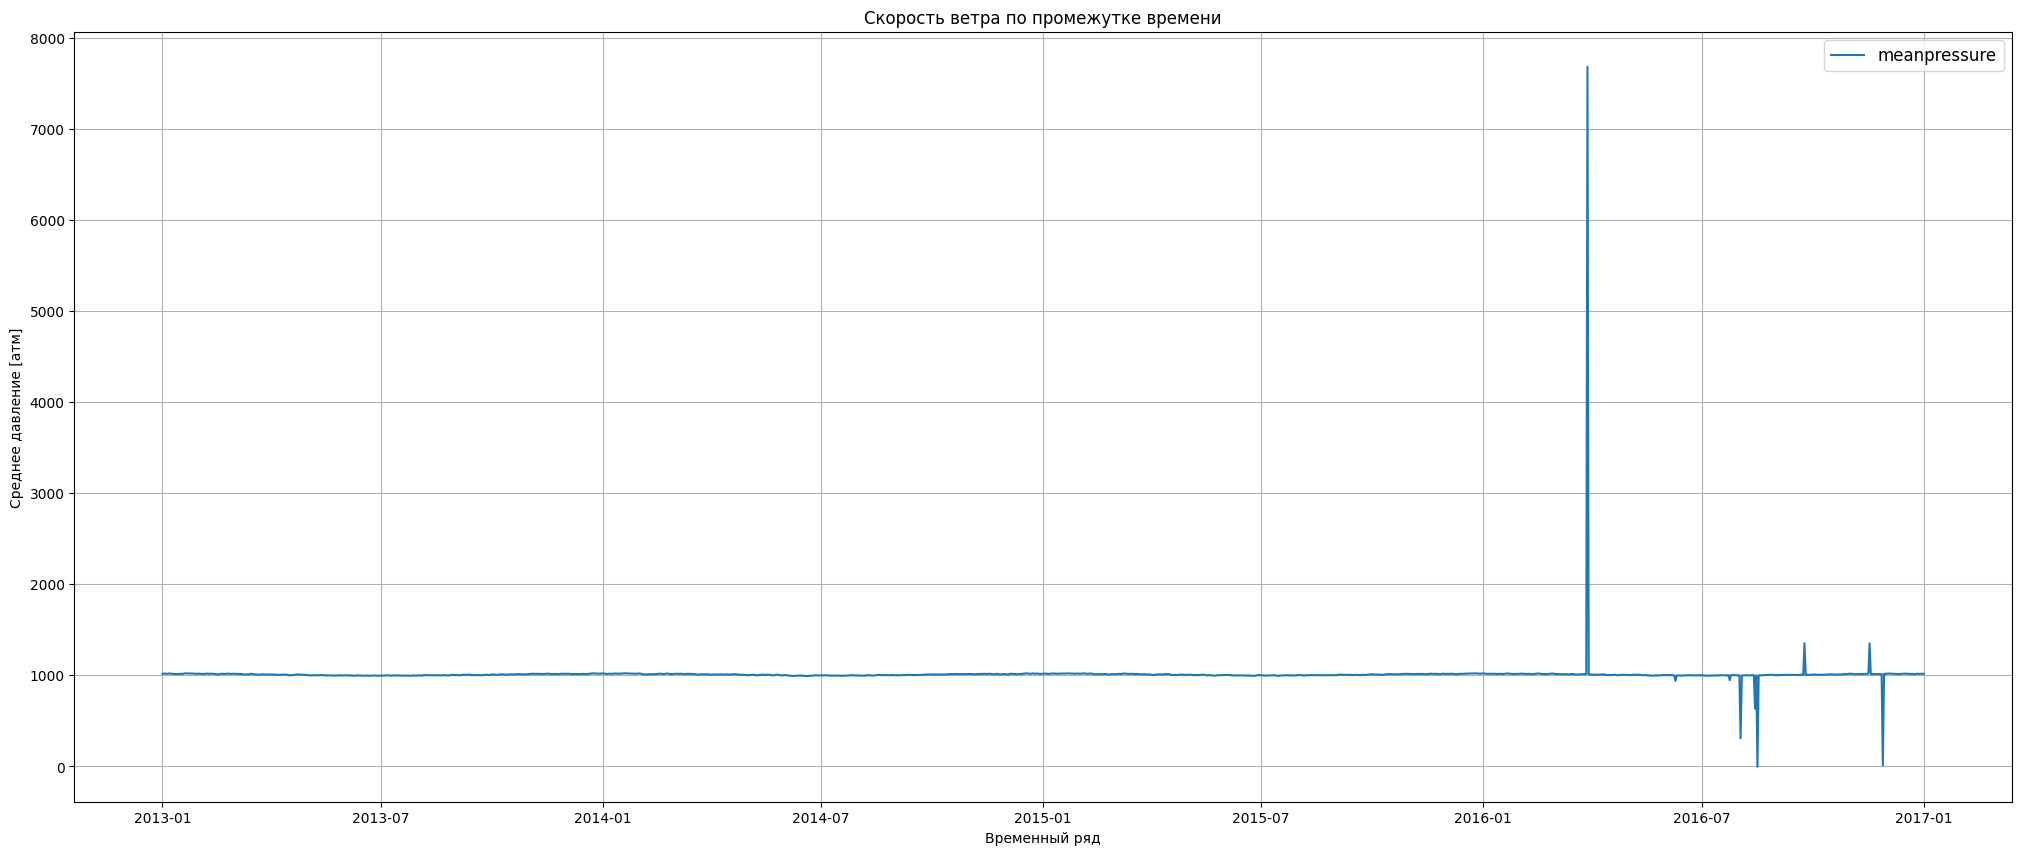

In [12]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['meanpressure'])
ax_year.grid()

plt.title('Скорость ветра по промежутке времени')
ax_year.set_xlabel('Временный ряд')
ax_year.set_ylabel('Среднее давление [атм]')
ax_year.legend(['meanpressure'], fontsize='larger')

plt.show()

In [13]:
df_train['meanpressure'].describe()

count    1462.000000
mean     1011.104548
std       180.231668
min        -3.041667
25%      1001.580357
50%      1008.563492
75%      1014.944901
max      7679.333333
Name: meanpressure, dtype: float64

Виден огромный выброс давления, устраняем его, поставим на нормальное ограничение - от 980 по 1100

In [14]:
df_train = df_train[(df_train['meanpressure'] < 1200) & (df_train['meanpressure'] > 980)]

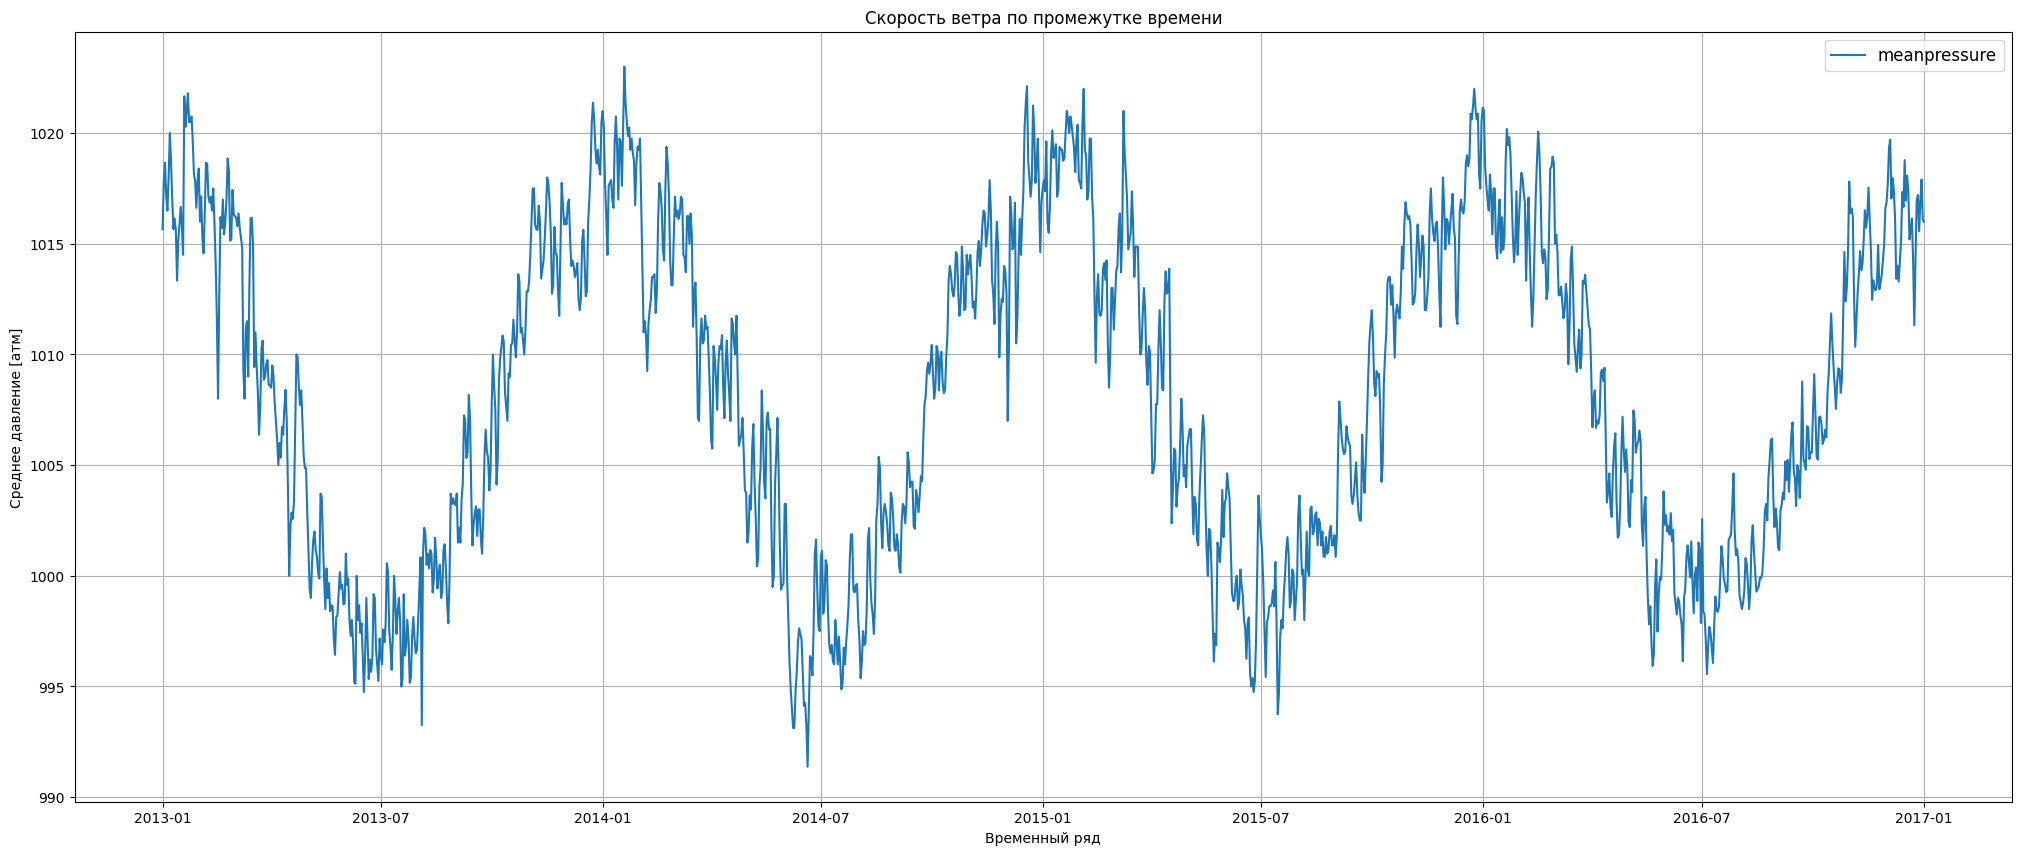

In [15]:
# Рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train.index, df_train['meanpressure'])
ax_year.grid()

plt.title('Скорость ветра по промежутке времени')
ax_year.set_xlabel('Временный ряд')
ax_year.set_ylabel('Среднее давление [атм]')
ax_year.legend(['meanpressure'], fontsize='larger')

plt.show()

Наблюдается корреляция с уровнем влажности - чем выше влажность, тем выше давление.

### График со скользящими средними

In [16]:
df_train_temp = df_train[['meantemp']]
df_test_temp = df_test[['meantemp']]

In [17]:
# Добавим скользящие среднее
df_train_temp['rolling_mean'] = df_train_temp.rolling(10).mean()
df_test_temp['rolling_mean'] = df_test_temp.rolling(10).mean()

/tmp/ipykernel_67490/4004936868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_temp['rolling_mean'] = df_train_temp.rolling(10).mean()
/tmp/ipykernel_67490/4004936868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_temp['rolling_mean'] = df_test_temp.rolling(10).mean()


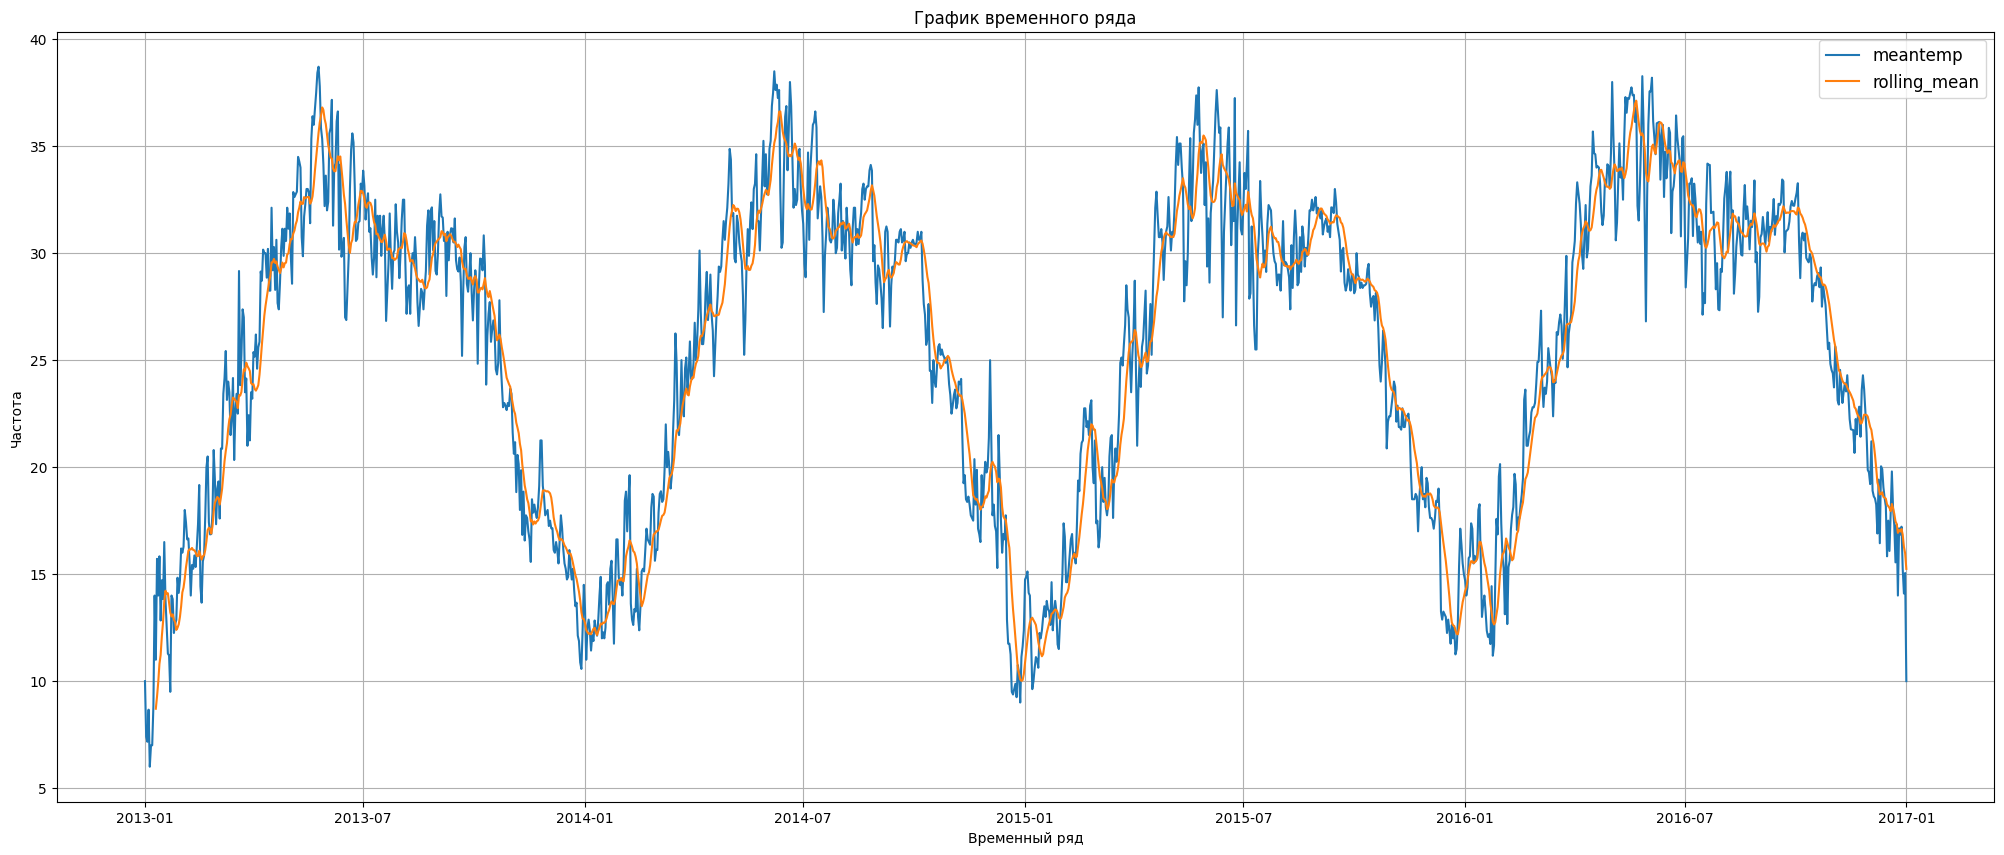

In [18]:
# И снова рассмотрим график и узнаем о нем
fig, ax_year = plt.subplots(figsize=(25,10))

ax_year.plot(df_train_temp.index, df_train_temp)
ax_year.grid()

plt.title('График временного ряда')
ax_year.set_xlabel('Временный ряд')
ax_year.set_ylabel('Частота')
ax_year.legend(df_train_temp, fontsize='larger')

plt.show()

Здесь получилось неудобной и неинформативной, рассмотрим определенный промежуток времени

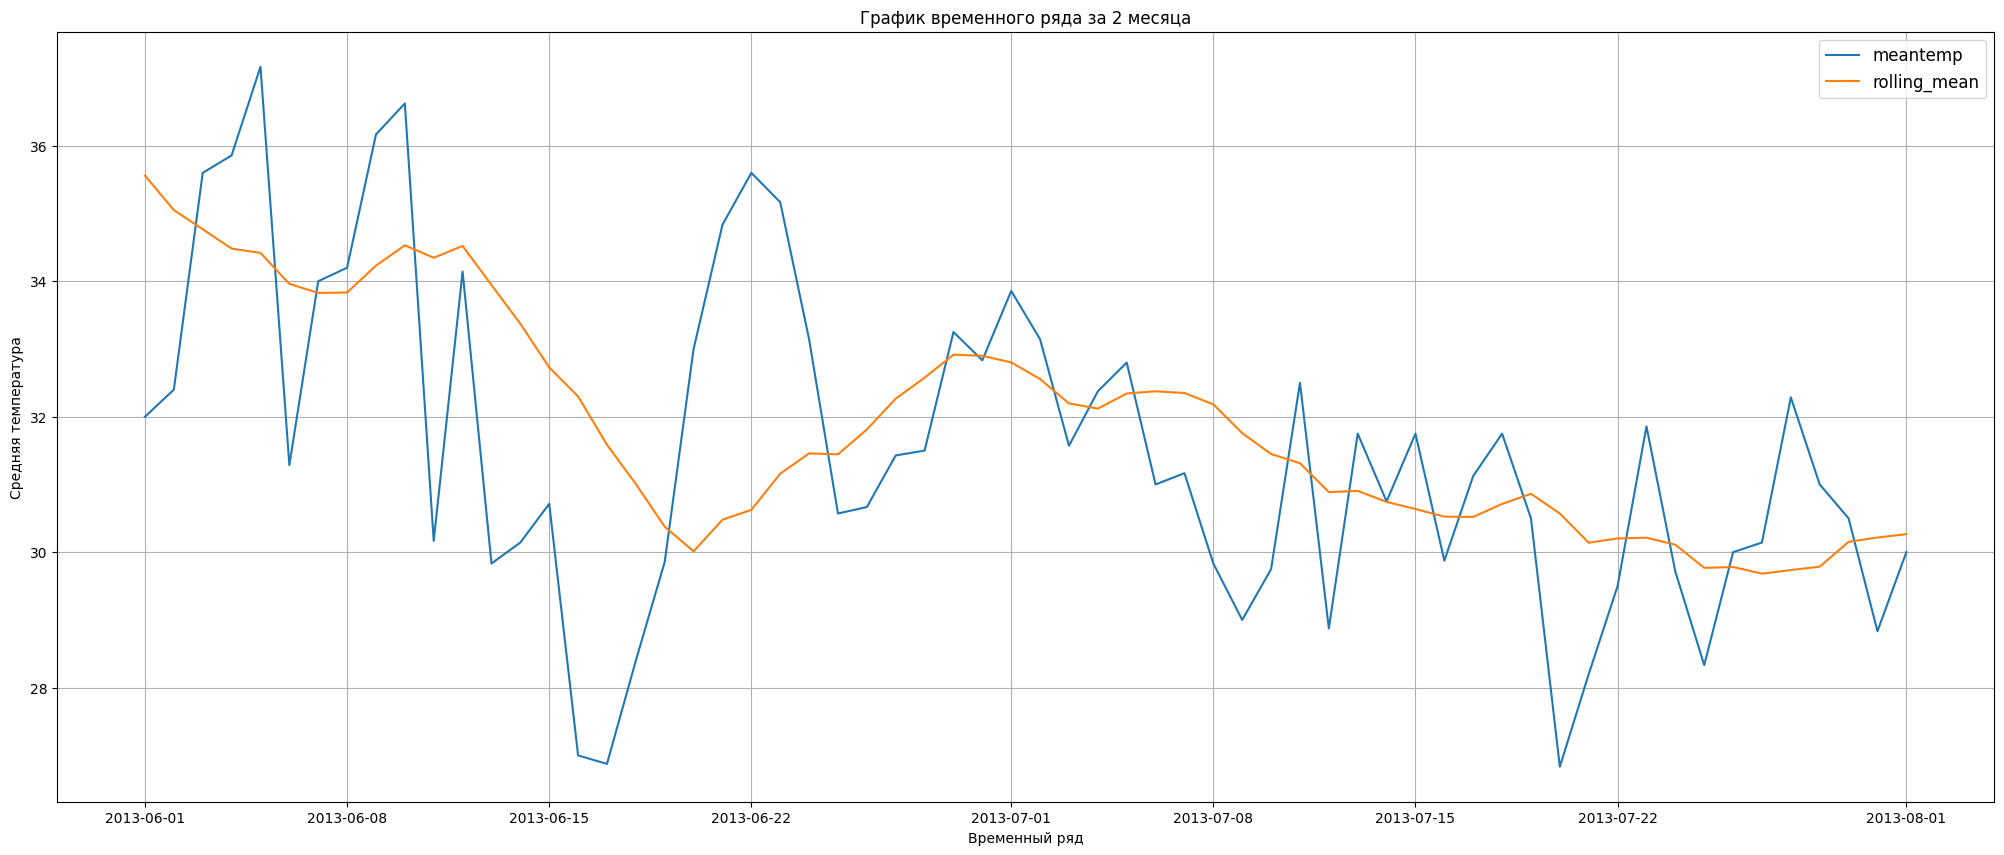

In [19]:
fig, ax_month = plt.subplots(figsize=(25,10))

# За неделю
ax_month.plot(df_train_temp['2013-06-01':'2013-08-01'].index, df_train_temp['2013-06-01':'2013-08-01'])
ax_month.grid()

plt.title('График временного ряда за 2 месяца')
ax_month.set_xlabel('Временный ряд')
ax_month.set_ylabel('Средняя температура')
ax_month.legend(df_train_temp, fontsize='larger')

plt.show()

Видно, что идет спад температуры к началу осени

### Исследуем стационарные ряды

In [20]:
df_train_temp['std'] = df_train_temp['meantemp'].rolling(15).std()
df_test_temp['std'] = df_test_temp['meantemp'].rolling(15).std()

/tmp/ipykernel_67490/1891657796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_temp['std'] = df_train_temp['meantemp'].rolling(15).std()
/tmp/ipykernel_67490/1891657796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_temp['std'] = df_test_temp['meantemp'].rolling(15).std()


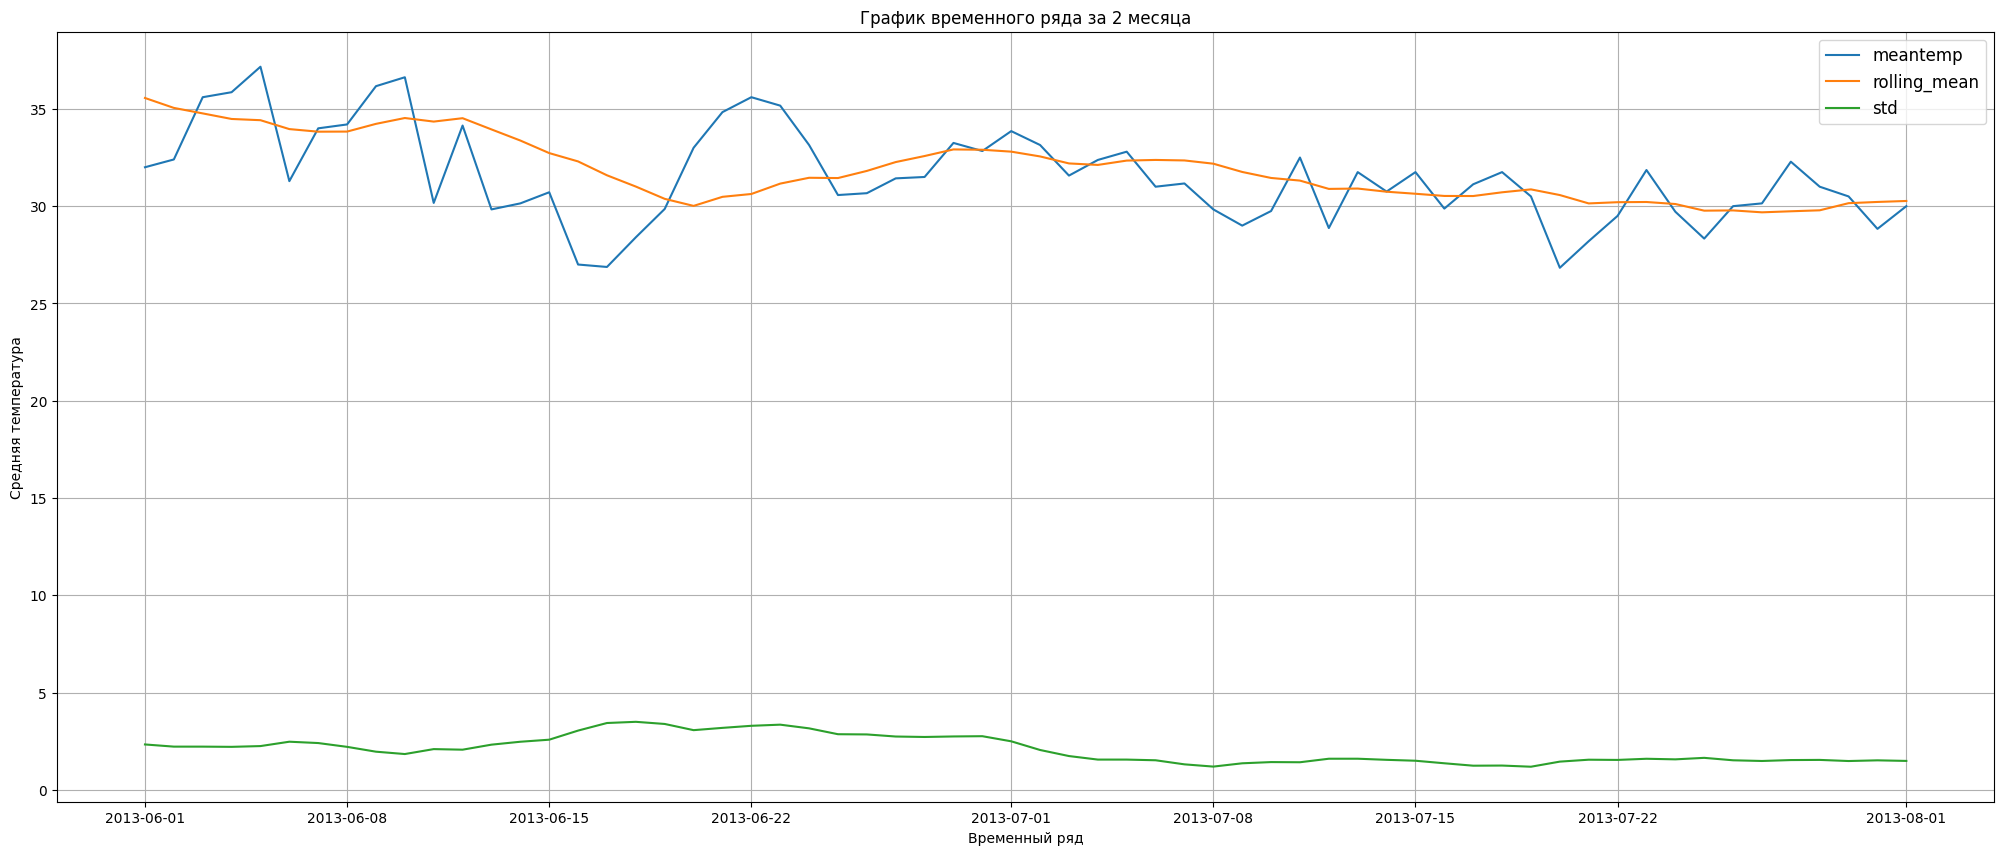

In [21]:
# И снова рассмотрим график и узнаем о нем
fig, ax_month = plt.subplots(figsize=(25,10))

# За месяца
ax_month.plot(df_train_temp['2013-06-01':'2013-08-01'].index, df_train_temp['2013-06-01':'2013-08-01'])
ax_month.grid()

plt.title('График временного ряда за 2 месяца')
ax_month.set_xlabel('Временный ряд')
ax_month.set_ylabel('Средняя температура')
ax_month.legend(df_train_temp, fontsize='larger')

plt.show()

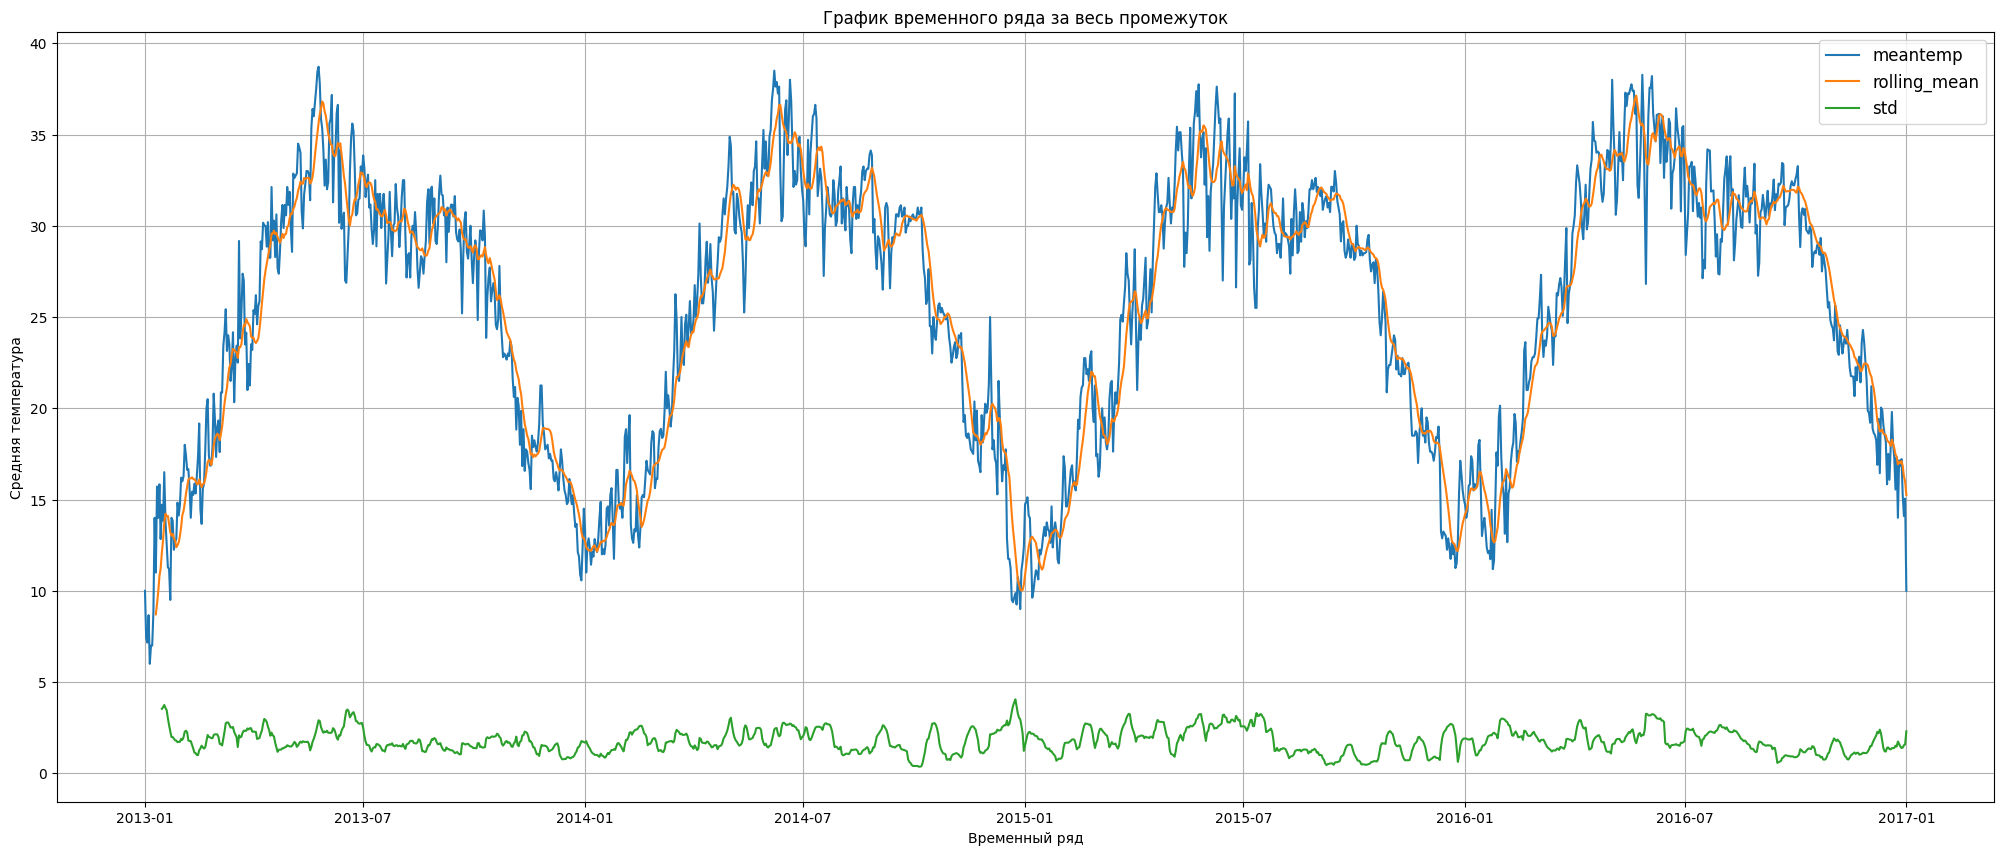

In [22]:
# И снова рассмотрим график и узнаем о нем
fig, ax_month = plt.subplots(figsize=(25,10))

# За месяца
ax_month.plot(df_train_temp.index, df_train_temp)
ax_month.grid()

plt.title('График временного ряда за весь промежуток')
ax_month.set_xlabel('Временный ряд')
ax_month.set_ylabel('Средняя температура')
ax_month.legend(df_train_temp, fontsize='larger')

plt.show()

*Примечание*:
- **Стохастический процесс** - это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются

Стохастический процесс стационарный (англ. stationary stochastic process), если его распределение со временем не меняется. Например, к такому процессу относятся периодические колебания значений

Если распределение меняется, то процесс называется нестационарным

А что насчет временный ряд, его можно назвать стационарным или нет - нельзя, пока не проверим на тренды, сезонность и остаток декомпозиции

### Тренды и сезонность

In [23]:
df_train_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1453 entries, 2013-01-01 to 2017-01-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1453 non-null   float64
 1   rolling_mean  1444 non-null   float64
 2   std           1439 non-null   float64
dtypes: float64(3)
memory usage: 77.7 KB


#### Тренд

In [24]:
# если период сезонности составляет 12 месяцев
decomposed = seasonal_decompose(df_train_temp['meantemp'], period=12)

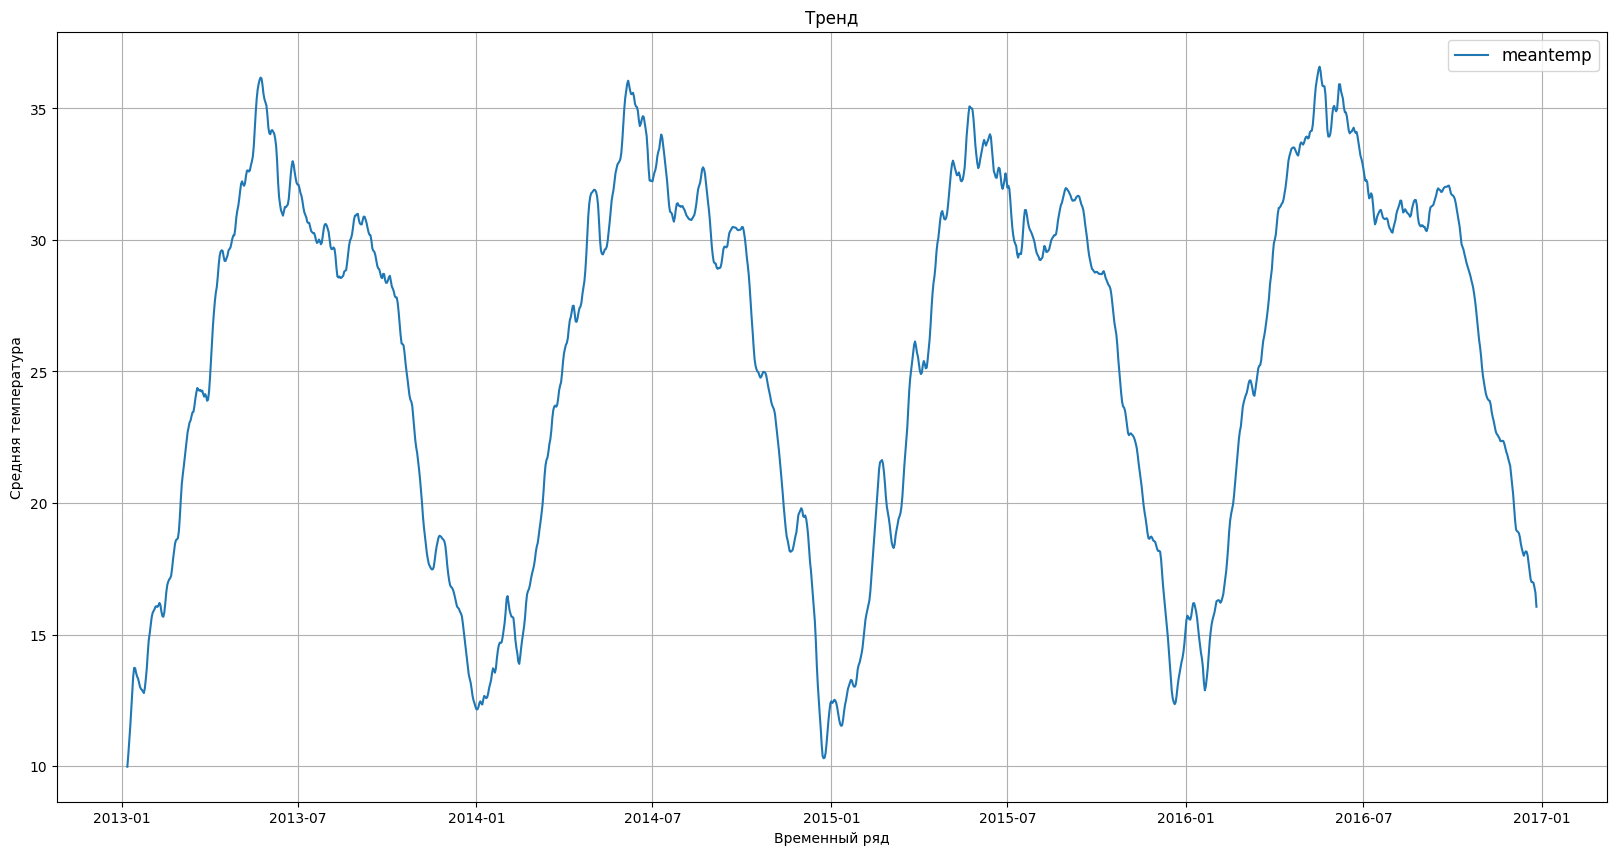

In [25]:
# Тренд
fig, ax_decomposed = plt.subplots(figsize=(20,10))

ax_decomposed.plot(decomposed.trend.index, decomposed.trend)
ax_decomposed.grid()

plt.title('Тренд')
ax_decomposed.set_xlabel('Временный ряд')
ax_decomposed.set_ylabel('Средняя температура')
ax_decomposed.legend(df_train_temp, fontsize='larger')

plt.show()

Видно, что тренд в последнее время увеличивается, т.е. с июня больше заказов на такси поступают нежели остальных

#### Сезонность

Рассмотрим сезонность в коротком промежутке, т.к. на длинном он не приносит мало полезных информаций. Рассмотрим за неделю

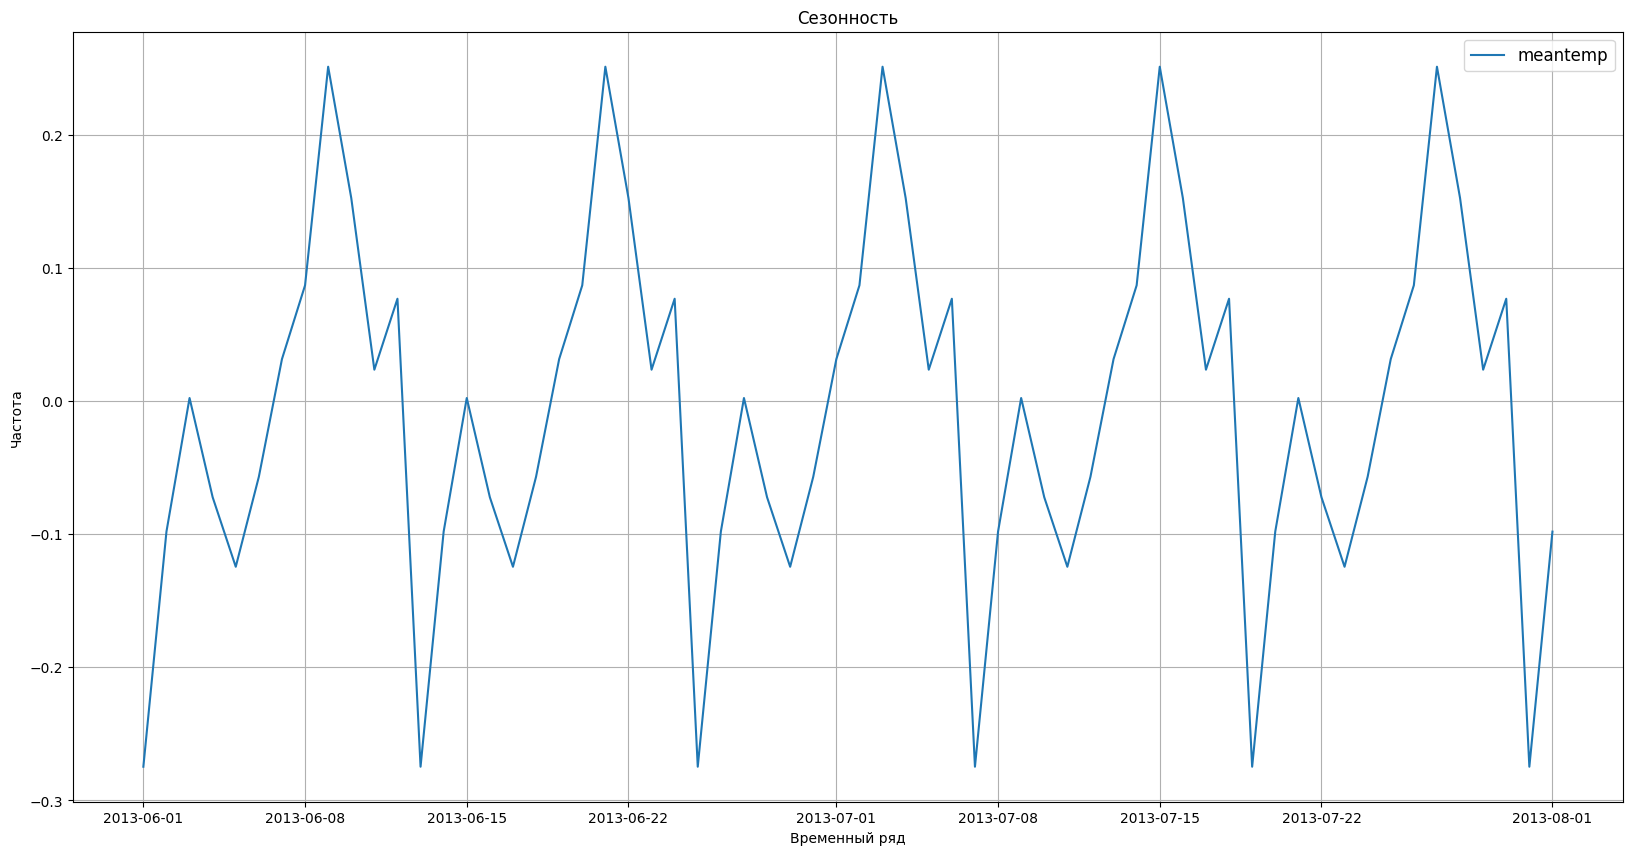

In [26]:
fig, ax_decomposed = plt.subplots(figsize=(20,10))

ax_decomposed.plot(decomposed.seasonal['2013-06-01':'2013-08-01'].index, decomposed.seasonal['2013-06-01':'2013-08-01'])
ax_decomposed.grid()

plt.title('Сезонность')
ax_decomposed.set_xlabel('Временный ряд')
ax_decomposed.set_ylabel('Частота')
ax_decomposed.legend(df_train_temp, fontsize='larger')

plt.show()

Как и видим, что график представляет собой цикличным способом (выглядит почти как кардиограмма сердца). Можно предполагать, что этот временный ряд стационарен, однако все равно лучше убедиться математическим способом, который приведен ниже

#### Остаток декомпозиции

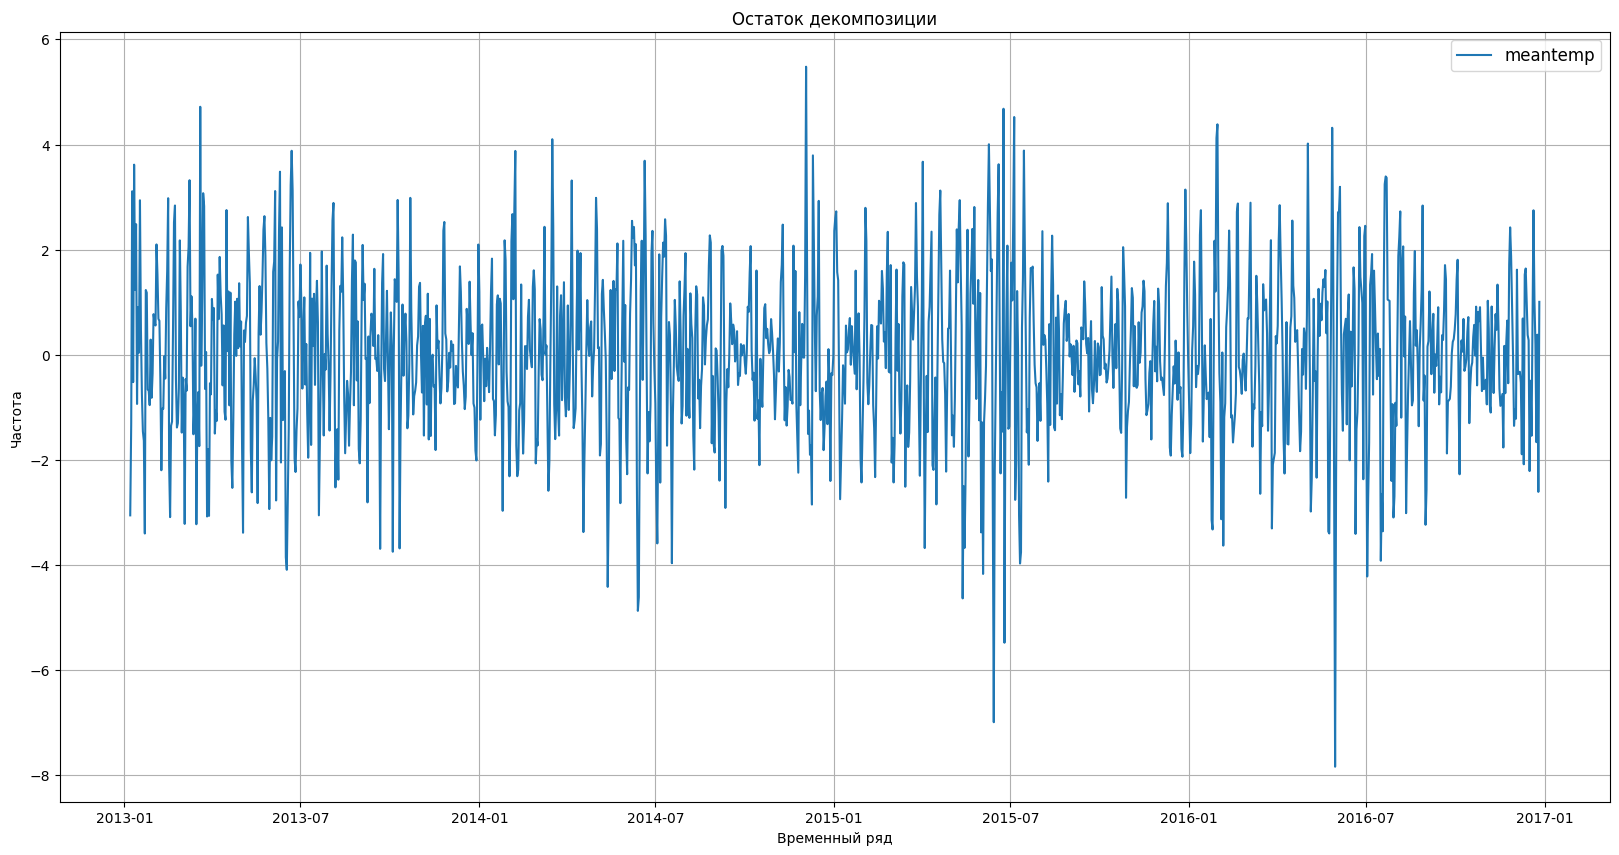

In [27]:
# Остаток декомпозиции
fig, ax_decomposed = plt.subplots(figsize=(20,10))

ax_decomposed.plot(decomposed.resid.index, decomposed.resid)
ax_decomposed.grid()

plt.title('Остаток декомпозиции')
ax_decomposed.set_xlabel('Временный ряд')
ax_decomposed.set_ylabel('Частота')
ax_decomposed.legend(df_train_temp, fontsize='larger')

plt.show()

По поводу остатка декомпозиции нужно провести исследование отдельно, причем детально, поскольку декомпозиции остатков интрепетировать сложнее, чем сезонность и тренды - в идеале, график остатков должен содержать только шум без систематических компонентов. 

Если остатки систематически распределены (например, отрицательны в первой части ряда и примерно равны нуля во второй) или включают некоторую периодическую компоненту, то это свидетельствует о неадекватности модели. Анализ остатков чрезвычайно важен и необходим при анализе временных рядов. Процедура оценивания предполагает, что остатки не коррелированы и нормально распределены.

### Проверка на дисперсию математическим способом

Можно проверить дисперсию, применяя теста Андерсона-Дарлинга

In [28]:
# x - временной ряд
# dist='norm' - ожидаемое распределение (нормальное)
result = anderson(x=df_train_temp['meantemp'], dist='norm')

# Статистика теста
test_statistic = result.statistic

# Критические значения для разных уровней значимости (1%, 5%, 10%)
critical_values = result.critical_values

# Если статистика теста больше критического значения для выбранного уровня значимости, то дисперсия не является постоянной
if test_statistic > critical_values[2]:
    print("Дисперсия не является постоянной")
else:
    print("Дисперсия является постоянной")

Дисперсия не является постоянной


Здесь можно сказать, что этот промежуток времени, т.е. с 2013 до конца, является нестанционарным, т.к. присутствует тренд, который стремится увеличиваться. А также дисперсия не является постоянной. Проверим на станционарность математическим способом, что она скажет

### Проверка на стационарность математическим способом

#### Тест Дики-Фуллера

In [29]:
print('='*100)
# тест Дики-Фуллера на стационарность
print('Тест Дики-Фуллера на стационарность')
print('='*100)
result = adfuller(df_train_temp['meantemp'])

print('ADF Статистка: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
print('='*100)

if(result[1] < 0.05):
    print('Принимаем альтернативную гипотезу. Временной ряд стационарен')
else:
    print('Отвергаем альтернативную гипотезу. Временной ряд не стационарен')
print('='*100)

Тест Дики-Фуллера на стационарность
ADF Статистка: -2.010274
p-value: 0.282086
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Отвергаем альтернативную гипотезу. Временной ряд не стационарен


#### Тест KPSS - Квятковский-Филлипс-Шмидт-ШинаДики-Фуллер 

In [30]:
print('='*100)
# KPSS-тест на стационарность
# KPSS - Квятковского-Филлипса-Шмидта-Шина
print('KPSS-тест на стационарность')
print('='*100)
result = kpss(df_train_temp['meantemp'])
print('KPSS Статистка: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))
    
print('='*100)
#### Тест Дики-Фуллера
if(result[1] < 0.05):
    print('Принимаем альтернативную гипотезу. Временной ряд стационарен')
else:
    print('Отвергаем альтернативную гипотезу. Временной ряд не стационарен')
print('='*100)

KPSS-тест на стационарность
KPSS Статистка: 0.182147
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Отвергаем альтернативную гипотезу. Временной ряд не стационарен


/tmp/ipykernel_67490/3606961055.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(df_train_temp['meantemp'])


2 разные теста одно и то же говорит, а по графику глазами не сможем судить, что является стационарен или не стационарен. Даже если приглядеться, то можно увидеть небольшой рост, хоть капельку

### Вывод

По графику видно, что, как обычно, перед началом сезоном осени, начинается спад температуры, а уровень влажности повышается. 

А также не стоит забывать, что заметен тренд.

Также на математическом языке были доказаны следующие тесты:
- На дисперсию
- На стационарность
    - Тест Дики-Фуллера
    - Тест KPSS - Квятковский-Филлипс-Шмидт-ШинаДики-Фуллер

Тест на дисперсию говорит, что не является постоянной, т.е. здесь получилось, что статистика теста больше критического значения для выбранного уровня значимости

А тесты на стационарность дали одинаковые результаты - отсутствует стационарность, значит, что распределение со временем меняется.

## Обучение и тестирование

In [31]:
# Здесь будем сохранить результаты машинного обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

In [32]:
# Создадим признаки, чтобы правильно обучить модель
def make_features(data, column, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

### Деление на обучающей и валидационной выборки

У нас есть 2 датасет: обучающий и тестовый

In [33]:
# На всякий случай сделаем копию, чтобы было удобно организовать несколько подборов
df_copy_train = df_train.copy()

df_copy_test = df_train.copy()

In [34]:
# Функция для создания новых признаков
make_features(df_copy_train, 'meantemp', 48, 96)
make_features(df_copy_test, 'meantemp', 48, 96)

In [35]:
features_train = df_copy_train.drop(['meantemp'], axis=1)
target_train = df_copy_train['meantemp']

features_test = df_copy_test.drop(['meantemp'], axis=1)
target_test = df_copy_test['meantemp']

In [36]:
# Проверим
print(features_train.shape)
print(features_test.shape)

(1453, 55)
(1453, 55)


In [37]:
# Проверим
display(features_train.head())
display(features_test.head())

humidity  wind_speed  meanpressure  hour  day  dayofweek  \
date                                                                    
2013-01-01  84.500000    0.000000   1015.666667     0    1          1   
2013-01-02  92.000000    2.980000   1017.800000     0    2          2   
2013-01-03  87.000000    4.633333   1018.666667     0    3          3   
2013-01-04  71.333333    1.233333   1017.166667     0    4          4   
2013-01-05  86.833333    3.700000   1016.500000     0    5          5   

                lag_1      lag_2  lag_3  lag_4  ...  lag_40  lag_41  lag_42  \
date                                            ...                           
2013-01-01        NaN        NaN    NaN    NaN  ...     NaN     NaN     NaN   
2013-01-02  10.000000        NaN    NaN    NaN  ...     NaN     NaN     NaN   
2013-01-03   7.400000  10.000000    NaN    NaN  ...     NaN     NaN     NaN   
2013-01-04   7.166667   7.400000   10.0    NaN  ...     NaN     NaN     NaN   
2013-01-05   8.666667   7.166667    7.4   10.0  ...     NaN     NaN     NaN   

            lag_43  lag_44  lag_45  lag_46  lag_47  lag_48  rolling_mean  
date                                                                      
2013-01-01     NaN     NaN     NaN     NaN     NaN     NaN           NaN  
2013-01-02     NaN     NaN     NaN     NaN     NaN     NaN           NaN  
2013-01-03     NaN     NaN     NaN     NaN     NaN     NaN           NaN  
2013-01-04     NaN     NaN     NaN     NaN     NaN     NaN           NaN  
2013-01-05     NaN     NaN     NaN     NaN     NaN     NaN           NaN  

[5 rows x 55 columns]

humidity  wind_speed  meanpressure  hour  day  dayofweek  \
date                                                                    
2013-01-01  84.500000    0.000000   1015.666667     0    1          1   
2013-01-02  92.000000    2.980000   1017.800000     0    2          2   
2013-01-03  87.000000    4.633333   1018.666667     0    3          3   
2013-01-04  71.333333    1.233333   1017.166667     0    4          4   
2013-01-05  86.833333    3.700000   1016.500000     0    5          5   

                lag_1      lag_2  lag_3  lag_4  ...  lag_40  lag_41  lag_42  \
date                                            ...                           
2013-01-01        NaN        NaN    NaN    NaN  ...     NaN     NaN     NaN   
2013-01-02  10.000000        NaN    NaN    NaN  ...     NaN     NaN     NaN   
2013-01-03   7.400000  10.000000    NaN    NaN  ...     NaN     NaN     NaN   
2013-01-04   7.166667   7.400000   10.0    NaN  ...     NaN     NaN     NaN   
2013-01-05   8.666667   7.166667    7.4   10.0  ...     NaN     NaN     NaN   

            lag_43  lag_44  lag_45  lag_46  lag_47  lag_48  rolling_mean  
date                                                                      
2013-01-01     NaN     NaN     NaN     NaN     NaN     NaN           NaN  
2013-01-02     NaN     NaN     NaN     NaN     NaN     NaN           NaN  
2013-01-03     NaN     NaN     NaN     NaN     NaN     NaN           NaN  
2013-01-04     NaN     NaN     NaN     NaN     NaN     NaN           NaN  
2013-01-05     NaN     NaN     NaN     NaN     NaN     NaN           NaN  

[5 rows x 55 columns]

In [38]:
# Проверим
display(features_train.tail())
display(features_test.tail())

humidity  wind_speed  meanpressure  hour  day  dayofweek  \
date                                                                     
2016-12-28   68.043478    3.547826   1015.565217     0   28          2   
2016-12-29   87.857143    6.000000   1016.904762     0   29          3   
2016-12-30   89.666667    6.266667   1017.904762     0   30          4   
2016-12-31   87.000000    7.325000   1016.100000     0   31          5   
2017-01-01  100.000000    0.000000   1016.000000     0    1          6   

                lag_1      lag_2      lag_3      lag_4  ...     lag_40  \
date                                                    ...              
2016-12-28  16.850000  17.142857  14.000000  17.318182  ...  21.769231   
2016-12-29  17.217391  16.850000  17.142857  14.000000  ...  21.730769   
2016-12-30  15.238095  17.217391  16.850000  17.142857  ...  20.666667   
2016-12-31  14.095238  15.238095  17.217391  16.850000  ...  22.250000   
2017-01-01  15.052632  14.095238  15.238095  17.217391  ...  21.538462   

               lag_41     lag_42     lag_43     lag_44     lag_45     lag_46  \
date                                                                           
2016-12-28  22.240000  23.346154  24.296296  23.538462  23.920000  23.518519   
2016-12-29  21.769231  22.240000  23.346154  24.296296  23.538462  23.920000   
2016-12-30  21.730769  21.769231  22.240000  23.346154  24.296296  23.538462   
2016-12-31  20.666667  21.730769  21.769231  22.240000  23.346154  24.296296   
2017-01-01  22.250000  20.666667  21.730769  21.769231  22.240000  23.346154   

               lag_47     lag_48  rolling_mean  
date                                            
2016-12-28  23.000000  23.730769     24.459510  
2016-12-29  23.518519  23.000000     24.290478  
2016-12-30  23.920000  23.518519     24.101708  
2016-12-31  23.538462  23.920000     23.935648  
2017-01-01  24.296296  23.538462     23.769529  

[5 rows x 55 columns]

humidity  wind_speed  meanpressure  hour  day  dayofweek  \
date                                                                     
2016-12-28   68.043478    3.547826   1015.565217     0   28          2   
2016-12-29   87.857143    6.000000   1016.904762     0   29          3   
2016-12-30   89.666667    6.266667   1017.904762     0   30          4   
2016-12-31   87.000000    7.325000   1016.100000     0   31          5   
2017-01-01  100.000000    0.000000   1016.000000     0    1          6   

                lag_1      lag_2      lag_3      lag_4  ...     lag_40  \
date                                                    ...              
2016-12-28  16.850000  17.142857  14.000000  17.318182  ...  21.769231   
2016-12-29  17.217391  16.850000  17.142857  14.000000  ...  21.730769   
2016-12-30  15.238095  17.217391  16.850000  17.142857  ...  20.666667   
2016-12-31  14.095238  15.238095  17.217391  16.850000  ...  22.250000   
2017-01-01  15.052632  14.095238  15.238095  17.217391  ...  21.538462   

               lag_41     lag_42     lag_43     lag_44     lag_45     lag_46  \
date                                                                           
2016-12-28  22.240000  23.346154  24.296296  23.538462  23.920000  23.518519   
2016-12-29  21.769231  22.240000  23.346154  24.296296  23.538462  23.920000   
2016-12-30  21.730769  21.769231  22.240000  23.346154  24.296296  23.538462   
2016-12-31  20.666667  21.730769  21.769231  22.240000  23.346154  24.296296   
2017-01-01  22.250000  20.666667  21.730769  21.769231  22.240000  23.346154   

               lag_47     lag_48  rolling_mean  
date                                            
2016-12-28  23.000000  23.730769     24.459510  
2016-12-29  23.518519  23.000000     24.290478  
2016-12-30  23.920000  23.518519     24.101708  
2016-12-31  23.538462  23.920000     23.935648  
2017-01-01  24.296296  23.538462     23.769529  

[5 rows x 55 columns]

In [39]:
# Проверим на пропущенные значения
print('-'*100)
print('features_train')
display(features_train.isna().sum())
print('-'*100)
print('features_test')
display(features_test.isna().sum())
print('-'*100)

----------------------------------------------------------------------------------------------------
features_train


humidity         0
wind_speed       0
meanpressure     0
hour             0
day              0
dayofweek        0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
lag_25          25
lag_26          26
lag_27          27
lag_28          28
lag_29          29
lag_30          30
lag_31          31
lag_32          32
lag_33          33
lag_34          34
lag_35          35
lag_36          36
lag_37          37
lag_38          38
lag_39          39
lag_40          40
lag_41          41
lag_42          42
lag_43          43
lag_44          44
lag_45          45
lag_46          46
lag_47      

----------------------------------------------------------------------------------------------------
features_test


humidity         0
wind_speed       0
meanpressure     0
hour             0
day              0
dayofweek        0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
lag_13          13
lag_14          14
lag_15          15
lag_16          16
lag_17          17
lag_18          18
lag_19          19
lag_20          20
lag_21          21
lag_22          22
lag_23          23
lag_24          24
lag_25          25
lag_26          26
lag_27          27
lag_28          28
lag_29          29
lag_30          30
lag_31          31
lag_32          32
lag_33          33
lag_34          34
lag_35          35
lag_36          36
lag_37          37
lag_38          38
lag_39          39
lag_40          40
lag_41          41
lag_42          42
lag_43          43
lag_44          44
lag_45          45
lag_46          46
lag_47      

----------------------------------------------------------------------------------------------------


Есть пропущенных значений, заполним их значением 0

In [40]:
features_train = features_train.fillna(0)
features_test = features_test.fillna(0)

In [41]:
# Проверим на пропущенные значения
print('-'*100)
print('features_train')
display(features_train.isna().sum())
print('-'*100)
print('features_test')
display(features_test.isna().sum())
print('-'*100)

----------------------------------------------------------------------------------------------------
features_train


humidity        0
wind_speed      0
meanpressure    0
hour            0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
lag_25          0
lag_26          0
lag_27          0
lag_28          0
lag_29          0
lag_30          0
lag_31          0
lag_32          0
lag_33          0
lag_34          0
lag_35          0
lag_36          0
lag_37          0
lag_38          0
lag_39          0
lag_40          0
lag_41          0
lag_42          0
lag_43          0
lag_44          0
lag_45          0
lag_46          0
lag_47          0
lag_48          0
rolling_mean    0
dtype: int

----------------------------------------------------------------------------------------------------
features_test


humidity        0
wind_speed      0
meanpressure    0
hour            0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
lag_25          0
lag_26          0
lag_27          0
lag_28          0
lag_29          0
lag_30          0
lag_31          0
lag_32          0
lag_33          0
lag_34          0
lag_35          0
lag_36          0
lag_37          0
lag_38          0
lag_39          0
lag_40          0
lag_41          0
lag_42          0
lag_43          0
lag_44          0
lag_45          0
lag_46          0
lag_47          0
lag_48          0
rolling_mean    0
dtype: int

----------------------------------------------------------------------------------------------------


**Обучение моделей с применением TimeSeriesSplit**

Почему обучаем с применением TimeSeriesSplit, потому что мы обучаем модель, у которой по индексу стоит временный ряд. А чтобы они не пересекались, это поможет инструмент TimeSeriesSplit. Как работает, рассмотрим ниже

In [42]:
# Не будем создавать по-умолчанию, где n_splits=5, а установим n_splits=10
tscv = TimeSeriesSplit(10)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)


In [43]:
for i, (train_index, test_index) in enumerate(tscv.split(features_train)):
    print(f"Fold {i}:")
    print('='*100)
    print(f"  Train: index={train_index}")
    print('='*100)
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132]
  Test:  index=[133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236

Как и видим, что разделен на несколько промежутков времени, по 10 блоков времени

### LinearRegression

In [44]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [45]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

RMSE TRAIN: 1.7265021600643666
TIME TRAIN [s]: 0.013
CPU times: user 471 ms, sys: 1.47 s, total: 1.94 s
Wall time: 190 ms


**Проверка на тестовой выборки**

In [46]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE
RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)
print('Предсказание:', predictions.mean())

RMSE TEST: 1.3881884345517503
Предсказание: 25.474857226913322
CPU times: user 33.2 ms, sys: 197 ms, total: 230 ms
Wall time: 15.9 ms


/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [47]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'LinearRegression', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### DecisionTreeRegressor

In [48]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 201, 10), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [49]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

RMSE TRAIN: 2.4798473050791143
TIME TRAIN [s]: 0.044
CPU times: user 11.2 s, sys: 625 ms, total: 11.8 s
Wall time: 11 s


**Проверка на тестовой выборки**

In [50]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)

print('Предсказание:', predictions.mean())

RMSE TEST: 0.4617334966388442
Предсказание: 25.47485722691331
CPU times: user 1.74 ms, sys: 2.96 ms, total: 4.69 ms
Wall time: 3.9 ms


/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'DecisionTreeRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### RandomForestRegressor

In [52]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [53]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

RMSE TRAIN: 2.313421956736468
TIME TRAIN [s]: 0.199
CPU times: user 3.22 s, sys: 0 ns, total: 3.22 s
Wall time: 3.23 s


/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validat

In [54]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)

print('Предсказание:', predictions.mean())

RMSE TEST: 0.6110882604583684
Предсказание: 25.480870139309683
CPU times: user 12.4 ms, sys: 0 ns, total: 12.4 ms
Wall time: 11.2 ms


/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [55]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'RandomForestRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### LightGBMRegressor

In [56]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [57]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1926
[LightGBM] [Info] Number of data points in the train set: 133, number of used features: 54
[LightGBM] [Info] Start training from score 21.332179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3933
[LightGBM] [Info] Number of data points in the train set: 265, number of used features: 54
[LightGBM] [Info] Start training from score 26.310085
[LightGBM] [Info] 

**Проверка на тестовой выборки**

In [58]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)
print('Предсказание:', predictions.mean())

RMSE TEST: 1.0668317416858537
Предсказание: 25.47485722712446
CPU times: user 379 µs, sys: 3.17 ms, total: 3.55 ms
Wall time: 3.21 ms


/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'LightGBMRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### CatBoostRegressor

In [60]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [5, 10],
              'learning_rate' : [0.05, 0.1],
              'iterations' : [5, 10]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [61]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

0:	learn: 7.1124362	total: 48.9ms	remaining: 195ms
1:	learn: 6.8359178	total: 50.4ms	remaining: 75.5ms
2:	learn: 6.5798315	total: 51.6ms	remaining: 34.4ms
3:	learn: 6.3596410	total: 53.1ms	remaining: 13.3ms
4:	learn: 6.1258755	total: 53.9ms	remaining: 0us
0:	learn: 7.1861256	total: 2.76ms	remaining: 11ms
1:	learn: 6.9055867	total: 3.96ms	remaining: 5.94ms
2:	learn: 6.6302659	total: 5.04ms	remaining: 3.36ms
3:	learn: 6.3866216	total: 5.95ms	remaining: 1.49ms
4:	learn: 6.1416103	total: 6.89ms	remaining: 0us
0:	learn: 7.4460521	total: 1.74ms	remaining: 6.95ms
1:	learn: 7.1543601	total: 3.65ms	remaining: 5.48ms
2:	learn: 6.8690458	total: 4.96ms	remaining: 3.31ms
3:	learn: 6.6064725	total: 6.31ms	remaining: 1.58ms
4:	learn: 6.3526133	total: 7.25ms	remaining: 0us
0:	learn: 7.2993058	total: 1.78ms	remaining: 7.11ms
1:	learn: 7.0165097	total: 3.61ms	remaining: 5.41ms
2:	learn: 6.7469267	total: 4.7ms	remaining: 3.13ms
3:	learn: 6.4722219	total: 5.66ms	remaining: 1.41ms
4:	learn: 6.2204444	total

**Проверка на тестовой выборки**

In [62]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)
print('Предсказание:', predictions.mean())

RMSE TEST: 3.437926624690185
Предсказание: 25.493696440144628
CPU times: user 8.73 ms, sys: 0 ns, total: 8.73 ms
Wall time: 6.31 ms


/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [63]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'CatBoostRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### XGBRegressor

In [64]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {"learning_rate": (0.05, 0.10),
              "max_depth": [5, 15],
              "min_child_weight": [1, 7],
              "gamma":[0.0, 0.2],
              "colsample_bytree":[0.3, 0.4],}

# Инициализируем модель c параметрами
model = GridSearchCV(xgb.XGBRegressor(), parameters, cv = tscv, scoring = 'neg_root_mean_squared_error')

In [65]:
%%time

# Обучим модель на обучающей выборке
model.fit(features_train, target_train)

# Узнаем RMSE обучающей выборки
RMSE_TRAIN = -model.best_score_
print('RMSE TRAIN:', RMSE_TRAIN)
print('TIME TRAIN [s]:', round(model.refit_time_, 3))

RMSE TRAIN: 1.959428219110506
TIME TRAIN [s]: 0.123
CPU times: user 40min 19s, sys: 7.34 s, total: 40min 26s
Wall time: 2min 48s


**Проверка на тестовой выборки**

In [66]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_test)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE_TEST = mean_squared_error(target_test, predictions, squared=False)
print('RMSE TEST:', RMSE_TEST)
print('Предсказание:', predictions.mean())

RMSE TEST: 0.7591525138783397
Предсказание: 25.47651
CPU times: user 32.8 ms, sys: 0 ns, total: 32.8 ms
Wall time: 8.05 ms


/home/redalexdad/anaconda3/envs/bmstu/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [67]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': 'XGBRegressor', 
    'RMSE TRAIN': RMSE_TRAIN, 
    'RMSE TEST': RMSE_TEST, 
    'PREDICTIONS': predictions, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PARAMETRS': model.best_params_
})

results[count_model]
count_model+=1

### Результаты

In [68]:
results = pd.DataFrame(results).T

In [69]:
# Смотрим на результаты
results

NAME RMSE TRAIN RMSE TEST  \
0       LinearRegression   1.726502  1.388188   
1  DecisionTreeRegressor   2.479847  0.461733   
2  RandomForestRegressor   2.313422  0.611088   
3      LightGBMRegressor    1.92885  1.066832   
4      CatBoostRegressor   4.178495  3.437927   
5           XGBRegressor   1.959428  0.759153   

                                         PREDICTIONS TIME TRAINING [s]  \
0  [3.6204892528395476, 8.573576828838725, 7.5690...          0.013156   
1  [9.333333333333332, 7.188888888888889, 7.18888...          0.044368   
2  [9.221333333333336, 8.02733333333333, 7.572809...          0.198989   
3  [9.239094110156824, 8.565478901217412, 8.44274...          0.009082   
4  [18.14933547799937, 18.14933547799937, 18.1493...          0.037562   
5  [8.577859, 7.8916597, 7.7544446, 9.231761, 7.7...          0.122964   

  TIME PREDICTION [s]                                          PARAMETRS  
0               0.012                                                 {}  
1               0.003           {'max_depth': 11, 'min_samples_leaf': 2}  
2               0.011  {'bootstrap': True, 'max_depth': 15, 'max_feat...  
3               0.002  {'learning_rate': 0.3, 'max_depth': 3, 'n_esti...  
4               0.005  {'depth': 5, 'iterations': 10, 'learning_rate'...  
5               0.007  {'colsample_bytree': 0.4, 'gamma': 0.2, 'learn...

In [70]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.5 * (1 - (results['RMSE TEST'] / results['RMSE TEST'].max())) +
    0.3 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max())) +
    0.2 * (1 - (results['TIME PREDICTION [s]'] / results['TIME PREDICTION [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [71]:
# Смотрим на результаты
results

NAME RMSE TRAIN RMSE TEST  \
1  DecisionTreeRegressor   2.479847  0.461733   
3      LightGBMRegressor    1.92885  1.066832   
5           XGBRegressor   1.959428  0.759153   
0       LinearRegression   1.726502  1.388188   
2  RandomForestRegressor   2.313422  0.611088   
4      CatBoostRegressor   4.178495  3.437927   

                                         PREDICTIONS TIME TRAINING [s]  \
1  [9.333333333333332, 7.188888888888889, 7.18888...          0.044368   
3  [9.239094110156824, 8.565478901217412, 8.44274...          0.009082   
5  [8.577859, 7.8916597, 7.7544446, 9.231761, 7.7...          0.122964   
0  [3.6204892528395476, 8.573576828838725, 7.5690...          0.013156   
2  [9.221333333333336, 8.02733333333333, 7.572809...          0.198989   
4  [18.14933547799937, 18.14933547799937, 18.1493...          0.037562   

  TIME PREDICTION [s]                                          PARAMETRS  \
1               0.003           {'max_depth': 11, 'min_samples_leaf': 2}   
3               0.002  {'learning_rate': 0.3, 'max_depth': 3, 'n_esti...   
5               0.007  {'colsample_bytree': 0.4, 'gamma': 0.2, 'learn...   
0               0.012                                                 {}   
2               0.011  {'bootstrap': True, 'max_depth': 15, 'max_feat...   
4               0.005  {'depth': 5, 'iterations': 10, 'learning_rate'...   

     RATING  
1  0.815957  
3  0.797818  
5  0.587541  
0  0.578272  
2  0.427792  
4  0.360037

Создадим отдельный датасет, в котором будет храниться реальное значение и предсказания модели

In [72]:
info_result = pd.DataFrame(index=target_test.index)
info_result['REAL'] = target_test
for i, name_model in enumerate(results['NAME']):
    info_result[name_model] = results['PREDICTIONS'][i]
info_result.head()

REAL  DecisionTreeRegressor  LightGBMRegressor  XGBRegressor  \
date                                                                            
2013-01-01  10.000000               3.620489           9.333333      9.221333   
2013-01-02   7.400000               8.573577           7.188889      8.027333   
2013-01-03   7.166667               7.569065           7.188889      7.572810   
2013-01-04   8.666667               8.079392           9.333333      8.470286   
2013-01-05   6.000000               8.734794           6.500000      7.251333   

            LinearRegression  RandomForestRegressor  CatBoostRegressor  
date                                                                    
2013-01-01          9.239094              18.149335           8.577859  
2013-01-02          8.565479              18.149335           7.891660  
2013-01-03          8.442745              18.149335           7.754445  
2013-01-04          9.905180              18.149335           9.231761  
2013-01-05          8.513889              18.149335           7.762185

Сразу все данные в одном графике нежелательно уложиться, т.к. не очень информативно, поэтому разобъем на 4 блока

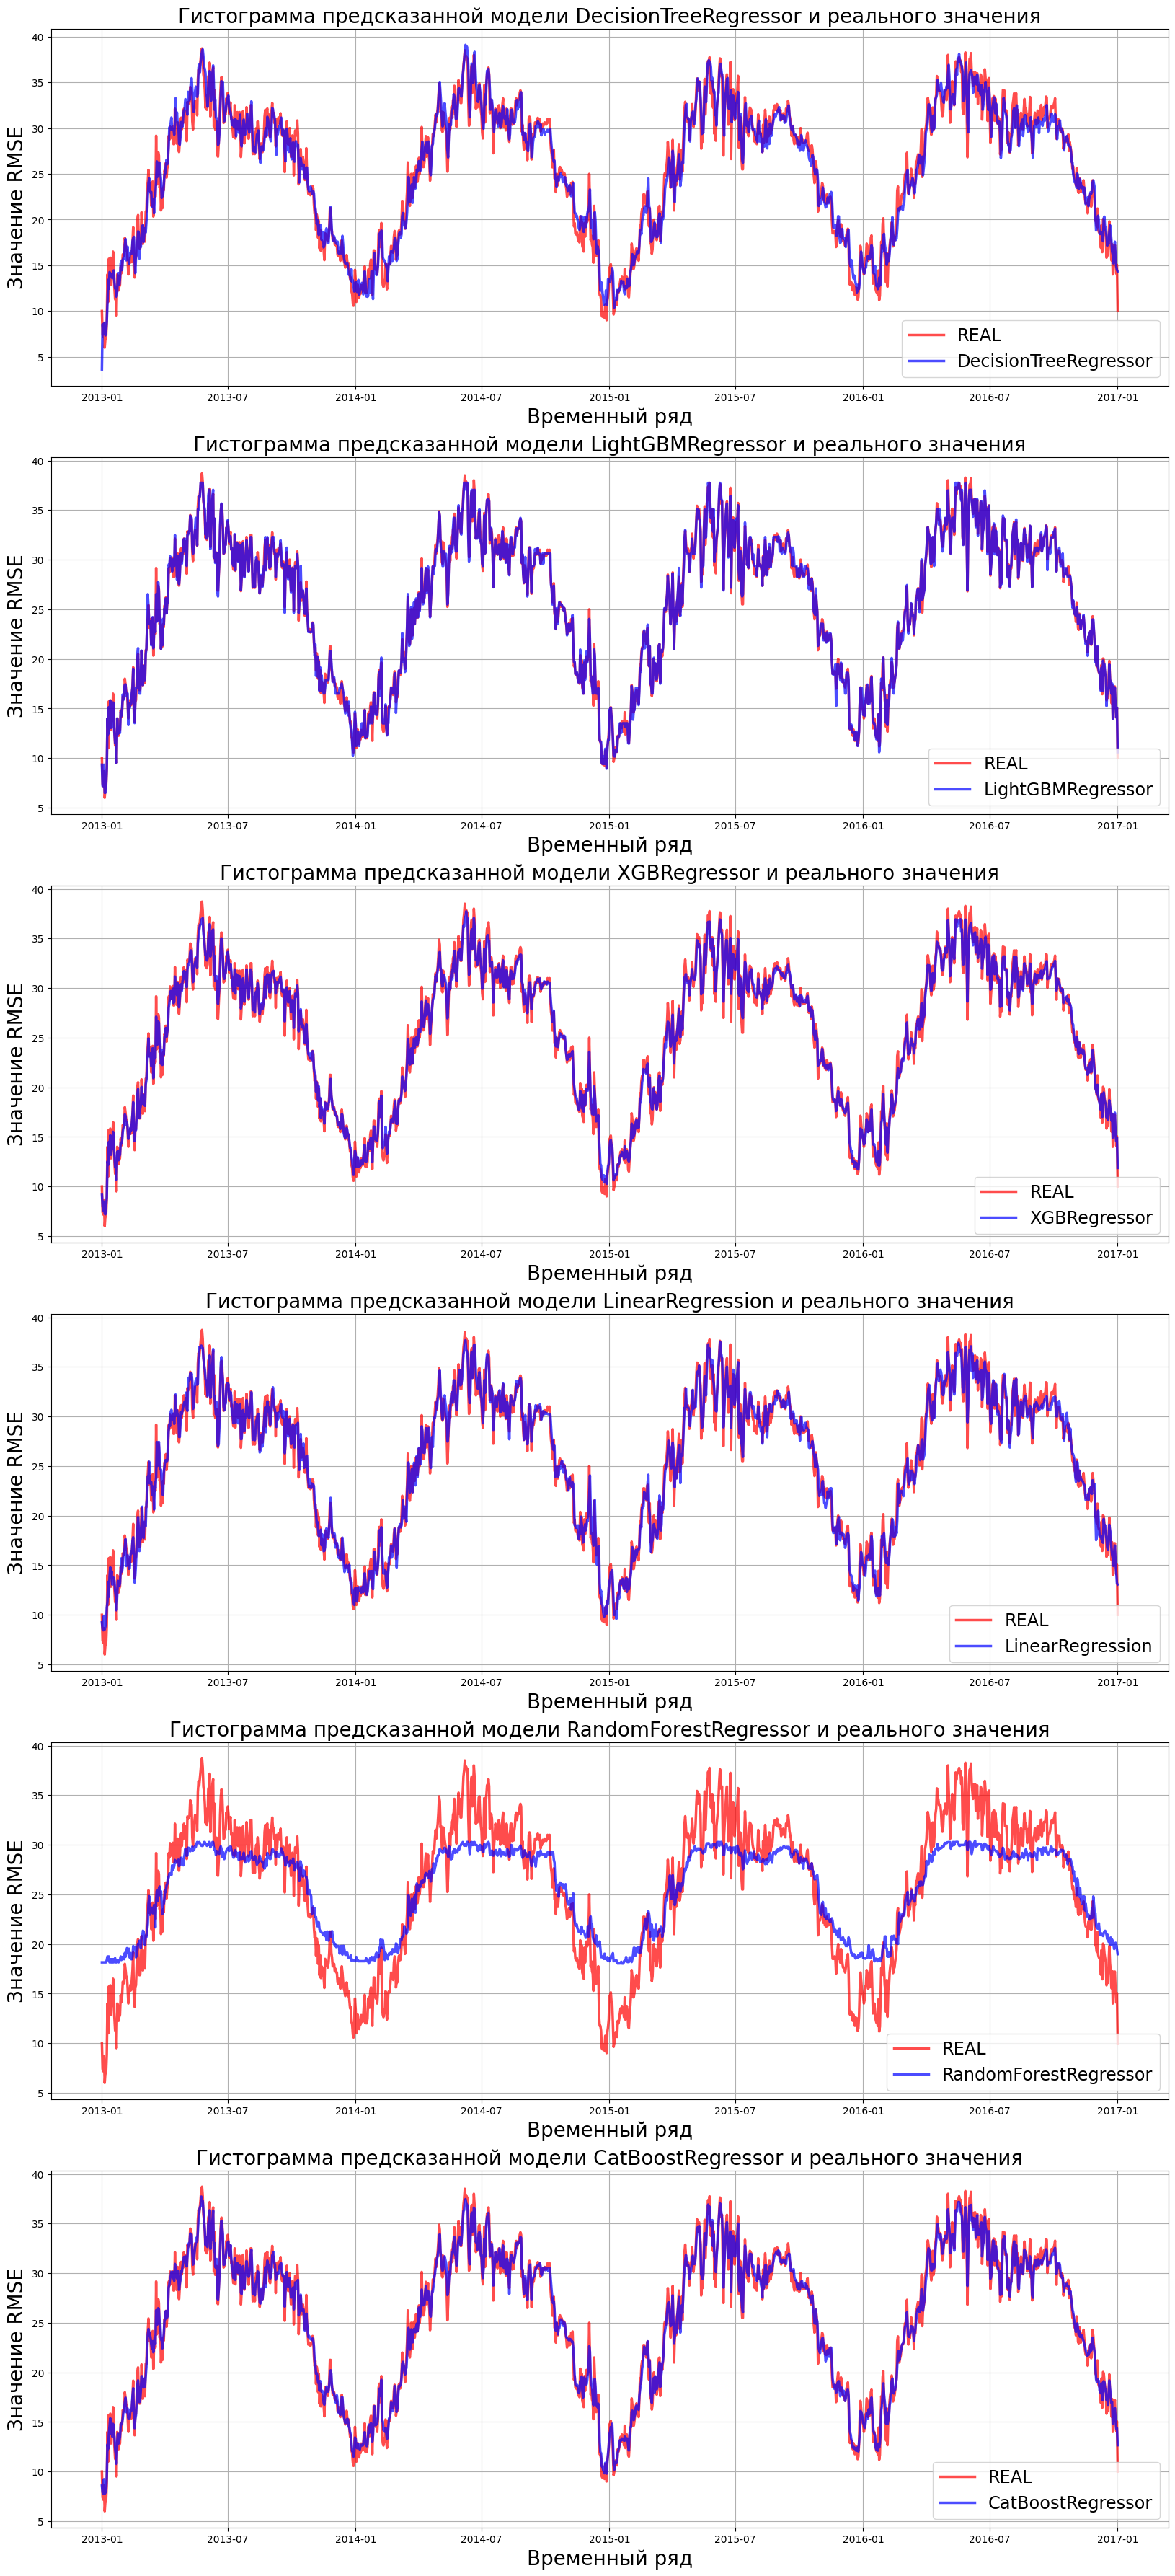

In [73]:
fig, ax = plt.subplots(6, figsize=(20, 45))

# Другие цветы тоже нежательны, они сливаются, лучше подобрать контрастные цветы
# colors = ['black', 'blue', 'orange', 'green']

for i in range(0, len(info_result.columns) - 1):
    # Посмотреть на гистограмме такое себе..., лучше на plot
    # ax[i].hist(info_result['REAL'], bins=(100), alpha=0.9, color=colors[i])
    # ax[i].hist(info_result[info_result.columns[i+1]], bins=(100), alpha=0.9, color=colors[i+1])
    ax[i].plot(info_result['REAL'], alpha=0.7, color='red', lw=2.5)
    ax[i].plot(info_result[info_result.columns[i+1]], alpha=0.7, color='blue', lw=2.5)
    ax[i].legend([info_result.columns[0], info_result.columns[i+1]], fontsize='xx-large')
    ax[i].grid()

    ax[i].set_xlabel('Временный ряд',fontsize=20)
    ax[i].set_ylabel('Значение RMSE',fontsize=20)
    ax[i].set_title(f'Гистограмма предсказанной модели {info_result.columns[i+1]} и реального значения',fontsize=20)
    
plt.show()

По графику видно, что предсказания модели в некотором степени отличаются от реальных значений

## Вывод

Самой лучшей моделей является `DecisionTreeRegressor` - RMSE составляет **0.461733**, а скорость обучения составляет почти 0.045 секунда, время предсказания - 0.003 секунда. Вполне очень акдеватный результат, чтобы выбрать эту модель для реализации. 

Есть другая модель - `LightGBMRegressor`, результаты очень неплохие, идеальный кандидат, чтобы конкурироваться с `XGBRegressor`

А четвертое место заслужила простая модель - `LinearRegression`, однако эта модель может похвастаться скоростью обучения и предсказанией